In [ ]:
!python --version

Python 3.7.12


# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Statements

In [ ]:
# install
!pip install geopandas

In [ ]:
# imports
import os
import csv
import requests
import numpy as np
import pandas as pd
import datetime as dt
import geopandas as gpd
from matplotlib import pyplot as plt

# Get Data

## API

### Get (all) Bus Routes for API Call

In [ ]:
# helper function
def extract_route_names(path, print_lines=True):
    with open(path) as f:
        lines = f.readlines()
    bus_lines = []
    for line in lines:
            found = line.partition('">')[2].partition("<")[0]
            if found != '':
              # next two lines remove '-SBS' distinction (not accepted by BusWatcher API)
              found = found.split('-') 
              found = found[0]
              bus_lines.append(found)
    if print_lines:
      for (i, line) in enumerate(bus_lines):
          print(i, line)
    return bus_lines

In [ ]:
# mta_bustime_routes_page_source.txt generated by copy/pasting https://bustime.mta.info/m/routes/ page source into text file
# note that while each route in the routes list generated below works as a query to the MTA's BusTime API, (i.e. https://bustime.mta.info/m/?q={route}), some do not seem to work with the BusWatcher API (e.g. M14A-SBS). unclear why...
routes = extract_route_names('/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Bus/mta_bustime_routes_page_source.txt', print_lines=False)
print(len(routes))

331


In [ ]:
# # number of routes (from MTA website): 234 local, 20 Select Bus Service, and 73 express bus routes in the five boroughs (https://new.mta.info/agency/new-york-city-transit/subway-bus-facts-2019)
# 234 + 20 + 73 = 327 vs 331 counted above...

In [ ]:
# save to drive
with open('/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Bus/routes.csv', 'w') as f:
  write = csv.writer(f)
  write.writerow(routes)

### Data Downloader

In [ ]:
# 10 busiest routes - source: https://new.mta.info/agency/new-york-city-transit/subway-bus-ridership-2020
# routes = ['M15', 'Bx12', 'B46', 'B6', 'B44', 'B35', 'Q58', 'B82', 'Bx19', 'B41']

In [ ]:
API_BASE_URL = 'http://api.buswatcher.org'
api_get_shipments_per_route = API_BASE_URL + '/api/v2/nyc/{route}/shipments'
api_get_single_shipment_geojson = API_BASE_URL + '/api/v2/nyc/{year}/{month}/{day}/{hour}/{route}/buses/geojson'

In [ ]:
# adapted from jeremy version, which first queried api for full shipment history (every year, every day, and every hour for every route in routes). alex version just queries for years, days, and hours needed
def retrieve_shipments(routes, years=None, months=None, days=None, hours=None):
    gdf = None
    for route in routes:
      print(route)
      for year in years:
        for month in months:
          for day in days:
            if month == 2:
              if year % 4 == 0:
                if day > 29:
                  continue
              else:
                if day > 28:
                  continue
            if month in {4, 6, 9, 11}:
              if day > 30:
                continue          
            print(f'{month}/{day}/{year}')
            for hour in hours:
              url = api_get_single_shipment_geojson.format(year=year, month=month, day=day, hour=hour, route=route)
              # try / except block for handling missing shipment
              try:
                gdf_temp = gpd.read_file(url)
                print(f'\t{hour}')
              except:
                print(f'\t{hour} missing')
                continue
              if gdf is not None:
                gdf = gdf.append(gdf_temp)
              else:
                gdf = gdf_temp
    return gdf

In [ ]:
def save_data(dir_path, routes, file_name=None, **kwargs):
    if file_name is None:
        file_name = 'nyc_buswatcher_api.geojson'
    
    root, ext = os.path.splitext(file_name)

    if ext != '.geojson':
        raise ValueError('File name extension must be .geojson')

    today = dt.date.today()
    file_name = f'{root}_{today}{ext}'
    file_path = os.path.join(dir_path, file_name)

    gdf = retrieve_shipments(routes, **kwargs)
    gdf.to_file(file_path, driver='GeoJSON')

    print(f'Data saved to {file_path}')

### Execute API Call

In [ ]:
# directory path
dir_path = os.path.join(os.getcwd(),
                        'drive',
                        'My Drive',
                        'Bus Watcher Spec Project',
                        'Projects',
                        'Alex Amy + Sanket Shah',
                        'Data',
                        'Bus',
                        'API Call'
                        )
dir_path

'/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Bus/API Call'

In [ ]:
# routes = ['M15']
# save_data(file_name='M15_v2.geojson', dir_path=dir_path, routes=routes, years=[2021], months=[i for i in range(8,10)], days=[i for i in range(1,32)], hours=[i for i in range(0,24)])

In [ ]:
# routes = ['Bx12']
# save_data(file_name='Bx12_v2.geojson', dir_path=dir_path, routes=routes, years=[2021], months=[i for i in range(8,10)], days=[i for i in range(1,32)], hours=[i for i in range(0,24)])

In [ ]:
# routes = ['B46']
# save_data(file_name='B46_v2.geojson', dir_path=dir_path, routes=routes, years=[2021], months=[i for i in range(8,10)], days=[i for i in range(1,32)], hours=[i for i in range(0,24)])

## Static

In [ ]:
# read keep_cols of static copies of api responses for M15, Bx12, and B46 (3 busiest routes); use concatenation across routes as proxy for full data (for now)...
# note gpd.read_file(path, ignore_geometry=True) returns pandas DataFrame (not geopandas GeoDataFrame)
# august + septmber
routes = ['M15', 'BX12', 'B46']
keep_cols = ['route', 'timestamp', 'next_stop_id', 'vehicle_id', 'passenger_count']

buswatcher_data = gpd.read_file('/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Bus/API Call/M15_2021-10-18.geojson', ignore_geometry=True)[keep_cols]
buswatcher_data = buswatcher_data.append(gpd.read_file('/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Bus/API Call/Bx12_2021-10-18.geojson', ignore_geometry=True)[keep_cols])
buswatcher_data = buswatcher_data.append(gpd.read_file('/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Bus/API Call/B46_2021-10-18.geojson', ignore_geometry=True)[keep_cols])
buswatcher_data.reset_index(drop=True, inplace=True)

In [ ]:
# count NaN values
buswatcher_data.isna().sum()

route                            0
timestamp                        0
route_long                       0
direction                        0
service_date                     0
trip_id                          0
gtfs_shape_id                    0
route_short                      0
agency                           0
origin_id                        0
destination_name                 0
next_stop_id                 14643
next_stop_eta                60303
next_stop_d_along_route      14643
next_stop_d                  14643
lat                              0
lon                              0
bearing                          0
progress_rate                    0
vehicle_id                       0
gtfs_block_id                57507
passenger_count             951245
progress_status             930490
destination_id             1099123
dtype: int64

In [ ]:
# compute max number of consecutive NaN values in next_stop_id
max_consecutive_next_stop_id_NaNs = {}
for route in routes:
  route_next_stop_ids = buswatcher_data[buswatcher_data['route'] == route]['next_stop_id']
  NaN_groups = route_next_stop_ids.notna().cumsum()[route_next_stop_ids.isna()]
  lengths_consecutive_NaN = NaN_groups.groupby(NaN_groups).agg(len)
  longest_NaN_group = lengths_consecutive_NaN.max()
  max_consecutive_next_stop_id_NaNs[route] = longest_NaN_group

max_consecutive_next_stop_id_NaNs

{'B46': 5, 'BX12': 5, 'M15': 6}

In [ ]:
# drop NaN next_stop_id values
buswatcher_data = buswatcher_data.dropna(subset=['next_stop_id'])

In [ ]:
# cast 'timestamp' column values as DateTime objects
buswatcher_data['timestamp']  = pd.to_datetime(buswatcher_data['timestamp'])

### Data Assumptions

In [ ]:
# no NaN values in following columns
no_nan_cols = ['route', 'timestamp', 'next_stop_id', 'vehicle_id']
for no_nan_col in no_nan_cols:
  num_nan = buswatcher_data[no_nan_col].isna().sum()
  try:
    assert num_nan == 0
  except AssertionError:
    print(f"Expected '{no_nan_col}' not to contain NaN values. Contained NaN values in {num_nan} rows representing {num_nan / buswatcher_data.shape[0]:.1%} of total observations")

# Exploratory Data Analysis



field definitions (http://web.mta.info/developers/resources/nyct/MTA-Bus-Time-fields.htm):

* `latitude Latitude` received from on-board GPS Unit (WGS84)

* `longitude Longitude` received from on-board GPS Unit (WGS84)

* `time_received` Time (in UTC) of message receipt by server.

* `vehicle_id` 3 or 4- digit bus number

* `distance_along_trip` Distance along trip (in meters)

* `inferred_direction_id` Direction ID from GTFS trips.txt

* `inferred_phase` The phase of the bus in its duty cycle; current extract includes only observations when the bus is inferred to be IN_PROGRESS (i.e. driving on the route) or LAYOVER_DURING (i.e. waiting at a terminal for a trip to begin)

* `inferred_route_id` Route ID the bus was inferred to be serving

* `inferred_trip_id` A GTFS trip_id representing the stopping pattern inferred for the given bus at the given time. Trip ID’s are only representative; they may not actually represent the trip a bus was serving.

* `next_scheduled_stop_distance` The distance of the bus (in meters) from that next stop

* `next_scheduled_stop_id` The GTFS stop_id of the next stop the bus will serve



## Helper Functions

In [ ]:
def to_hist(data, xlabel):  
  data = np.array(data)
  data_avg = data.mean()
  data_std = data.std()
  plt.figure(figsize=(20, 10))
  plt.hist(data)
  plt.axvline(data_avg, color='red')
  min_ylim, max_ylim = plt.ylim()
  plt.xlabel(xlabel)
  plt.ylabel('Count')
  plt.title(f'Distribution of {xlabel}: avg - {data_avg:.3f} | std - {data_std:.3f}')
  plt.show()

def make_hists(df, xlabels):
  for key in sorted(xlabels):
    data = df[key]
    xlabel = xlabels[key]
    to_hist(data, xlabel)
    print('\n')

def generate_quarter_hour_intervals():
  start = []
  end = []
  time = dt.datetime(2021,8,1)
  for i in range(96):
    start.append(time.time())
    time = time + dt.timedelta(minutes=15)
    end.append(time.time())
  return list(zip(start,end)) 

## Constants

In [ ]:
hours_of_day = list(range(24))
quarter_hour_intervals = generate_quarter_hour_intervals()
days_of_week = [0, 1, 2, 3, 4, 5, 6]
days_of_week_str = ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']
observation_window_start = buswatcher_data.timestamp.min()
observation_window_end = buswatcher_data.timestamp.max()
observation_window_dates = pd.date_range(start=observation_window_start, end=observation_window_end)
observation_window_duration = observation_window_end - observation_window_start

## Basic Stats

In [ ]:
buswatcher_data.head()

,index,route,timestamp,next_stop_id,vehicle_id,passenger_count
0,0,M15,2021-08-01 00:00:50-04:00,MTA_401701,MTA NYCT_5913,NaN
1,1,M15,2021-08-01 00:00:52-04:00,MTA_404844,MTA NYCT_6045,10.0
2,2,M15,2021-08-01 00:00:56-04:00,MTA_401771,MTA NYCT_5889,NaN
3,3,M15,2021-08-01 00:00:57-04:00,MTA_401682,MTA NYCT_6049,6.0
4,4,M15,2021-08-01 00:01:00-04:00,MTA_401765,MTA NYCT_5828,NaN


In [ ]:
buswatcher_data.shape

(2733978, 6)

In [ ]:
buswatcher_vehicles = set(buswatcher_data['vehicle_id'])
buswatcher_stops = set(buswatcher_data['next_stop_id'])
buswatcher_routes = set(buswatcher_data['route'])

total_vehicles = 5927 # source: https://new.mta.info/agency/new-york-city-transit/subway-bus-facts-2019
total_stops = 16350 # source: https://www.wired.com/story/nyc-redesigning-ponderous-bus/
total_routes = len(routes) # source: https://bustime.mta.info/m/routes/

print(f'observation window start: \t{observation_window_start}')
print(f'observation window end: \t{observation_window_end}')
print(f'observation window duration: \t{observation_window_duration}\n')
print(f'bus network components observed during observation window:\n')
print(f'vehicles: \t{len(buswatcher_vehicles)}/{total_vehicles} \t({len(buswatcher_vehicles) / 5927:.1%})') 
print(f'stops: \t\t{len(buswatcher_stops)}/{total_stops} \t({len(buswatcher_stops) / 16350:.1%})')  
print(f'routes: \t{len(buswatcher_routes)}/{total_routes} \t\t({len(buswatcher_routes) / len(routes):.1%})') 
print(f'missing routes:\n')
missing_routes = [missing_route for missing_route in list(set(routes) - set(buswatcher_routes))]
missing_routes.sort()
for missing_route in missing_routes:
  print(missing_route)

observation window start: 	2021-08-01 00:00:50-04:00
observation window end: 	2021-09-30 23:59:26-04:00
observation window duration: 	60 days 23:58:36

bus network components observed during observation window:

vehicles: 	602/5927 	(10.2%)
stops: 		303/16350 	(1.9%)
routes: 	3/3 		(100.0%)
missing routes:



## Route Stats

### Compute Stats DataFrame

In [ ]:
routes_dict = {}

for route in buswatcher_routes:
  route_data = buswatcher_data[buswatcher_data['route'] == route]
  
  if route_data.shape[0] != 0:
    route_stops = set(route_data['next_stop_id'])
    route_vehicles = set(route_data['vehicle_id'])
    
    num_route_observations = np.float64(route_data.shape[0]) # for handling div0 errors
    num_route_stops = np.float64(len(route_stops)) # for handling div0 errors
    num_route_vehicles = np.float64(len(route_vehicles)) # for handling div0 errors
    num_route_non_nan_passenger_counts = route_data['passenger_count'].notna().sum()

    if num_route_non_nan_passenger_counts == 0:
      pct_route_non_nan_passenger_counts = 0
    else:  
      pct_route_non_nan_passenger_counts = num_route_non_nan_passenger_counts / num_route_observations

    if num_route_observations == 0:
      norm_route_observations = 0
    else:
      norm_route_observations = num_route_observations / num_route_vehicles

    daily_num_route_observations = []
    daily_num_route_stops = []
    daily_num_route_vehicles = []
    daily_num_route_non_nan_passenger_counts = []

    daily_pct_route_stops = []
    daily_pct_route_non_nan_passenger_counts = []

    daily_norm_route_observations = []

    ####################
    qhly_num_route_stops = []
    qhly_num_route_non_nan_passenger_counts = []

    qhly_pct_route_stops = []
    qhly_pct_route_non_nan_passenger_counts = []
    ####################

    start = route_data.timestamp.min()
    end = route_data.timestamp.max()
    dates = pd.date_range(start=start, end=end)

    for date in dates:
      day_route_data = route_data[route_data['timestamp'].dt.date == date.date()]
      day_route_stops = set(day_route_data['next_stop_id'])
      day_route_vehicles = set(day_route_data['vehicle_id'])

      day_num_route_observations = np.float64(day_route_data.shape[0]) # for handling div0 errors
      day_num_route_stops = len(day_route_stops)
      day_num_route_vehicles = np.float64(len(day_route_vehicles)) # for handling div0 errors
      day_num_route_non_nan_passenger_counts = day_route_data['passenger_count'].notna().sum()

      if day_num_route_stops == 0:
        day_pct_route_stops = 0
      else:
        day_pct_route_stops = day_num_route_stops / num_route_stops
      if day_num_route_non_nan_passenger_counts == 0:
        day_pct_route_non_nan_passenger_counts = 0
      else:
        day_pct_route_non_nan_passenger_counts = day_num_route_non_nan_passenger_counts / day_num_route_observations

      if day_num_route_observations == 0:
        day_norm_route_observations = 0
      else:
        day_norm_route_observations = day_num_route_observations / day_num_route_vehicles

      daily_num_route_observations.append(day_num_route_observations)
      daily_num_route_stops.append(day_num_route_stops)
      daily_num_route_vehicles.append(day_num_route_vehicles)
      daily_num_route_non_nan_passenger_counts.append(day_num_route_non_nan_passenger_counts)

      daily_pct_route_stops.append(day_pct_route_stops)
      daily_pct_route_non_nan_passenger_counts.append(day_pct_route_non_nan_passenger_counts)

      daily_norm_route_observations.append(day_norm_route_observations)

      ####################
      for (start, end) in quarter_hour_intervals:
        qh_route_data = day_route_data[(day_route_data['timestamp'].dt.time >= start) & (day_route_data['timestamp'].dt.time < end)]
        qh_route_stops = set(qh_route_data['next_stop_id'])
        
        qh_num_route_stops = len(qh_route_stops)
        qh_num_route_non_nan_passenger_counts = qh_route_data['passenger_count'].notna().sum()

        if qh_num_route_stops == 0:
          qh_pct_route_stops = 0
        else:  
          qh_pct_route_stops = qh_num_route_stops / num_route_stops
        if qh_num_route_non_nan_passenger_counts == 0:
          qh_pct_route_non_nan_passenger_counts = 0
        else:
          qh_pct_route_non_nan_passenger_counts = qh_num_route_non_nan_passenger_counts / day_num_route_observations

        qhly_num_route_stops.append(qh_num_route_stops)
        qhly_num_route_non_nan_passenger_counts.append(qh_num_route_non_nan_passenger_counts)

        qhly_pct_route_stops.append(qh_pct_route_stops)
        qhly_pct_route_non_nan_passenger_counts.append(qh_pct_route_non_nan_passenger_counts)
      ####################
        
    daily_num_route_observations = np.array(daily_num_route_observations)
    daily_num_route_stops = np.array(daily_num_route_stops)
    daily_num_route_vehicles = np.array(daily_num_route_vehicles)
    daily_num_route_non_nan_passenger_counts = np.array(daily_num_route_non_nan_passenger_counts)

    daily_pct_route_stops = np.array(daily_pct_route_stops)
    daily_pct_route_non_nan_passenger_counts = np.array(daily_pct_route_non_nan_passenger_counts)

    daily_norm_route_observations = np.array(daily_norm_route_observations)

    ####################
    qhly_num_route_stops = np.array(qhly_num_route_stops)
    qhly_num_route_non_nan_passenger_counts = np.array(qhly_num_route_non_nan_passenger_counts)

    qhly_pct_route_stops = np.array(qhly_pct_route_stops)
    qhly_pct_route_non_nan_passenger_counts = np.array(qhly_pct_route_non_nan_passenger_counts)
    ####################

    routes_dict[route] = {
        'obs:gros:total':num_route_observations,
        'obs:gros:daily:avg':daily_num_route_observations.mean(),
        'obs:gros:daily:std':daily_num_route_observations.std(),
        'obs:norm/vhcls:total':norm_route_observations,
        'obs:norm/vhcls:daily:avg':daily_norm_route_observations.mean(),
        'obs:norm/vhcls:daily:std':daily_norm_route_observations.std(),
        'stops:total':num_route_stops,
        'stops:daily:avg':daily_num_route_stops.mean(),
        'stops:daily:std':daily_num_route_stops.std(),
        'stops:pct/tot_stops:daily:avg':daily_pct_route_stops.mean(),
        'stops:pct/tot_stops:daily:std':daily_pct_route_stops.std(),
        
        ####################
        'stops:qh:avg':qhly_num_route_stops.mean(),
        'stops:qh:std':qhly_num_route_stops.std(),
        'stops:pct/tot_stops:qh:avg':qhly_pct_route_stops.mean(),
        'stops:pct/tot_stops:qh:std':qhly_pct_route_stops.std(),
        ####################
        
        'vhcls:total':num_route_vehicles,
        'vhcls:daily:avg':daily_num_route_vehicles.mean(),
        'vhcls:daily:std':daily_num_route_vehicles.std(),
        'non_nans:gros:total':num_route_non_nan_passenger_counts,
        'non_nans:gros:daily:avg':daily_num_route_non_nan_passenger_counts.mean(),
        'non_nans:gros:daily:std':daily_num_route_non_nan_passenger_counts.std(),

        ####################
        'non_nans:gros:qh:avg':qhly_num_route_non_nan_passenger_counts.mean(),
        'non_nans:gros:qh:std':qhly_num_route_non_nan_passenger_counts.std(),
        ####################
        
        'non_nans:pct/tot_obs:total':pct_route_non_nan_passenger_counts,
        'non_nans:pct/tot_obs:daily:avg':daily_pct_route_non_nan_passenger_counts.mean(),
        'non_nans:pct/tot_obs:daily:std':daily_pct_route_non_nan_passenger_counts.std(),

        ####################
        'non_nans:pct/tot_obs:qh:avg':qhly_pct_route_non_nan_passenger_counts.mean(),
        'non_nans:pct/tot_obs:qh:std':qhly_pct_route_non_nan_passenger_counts.std()
        ####################
    }

routes_df = pd.DataFrame.from_dict(routes_dict, orient='index')
assert routes_df.shape[0] == len(buswatcher_routes)
routes_df.shape

(3, 28)

In [ ]:
# save to drive
routes_df.to_csv('/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Bus/API Call/M15_BX12_B46_routes.csv')

### Plot Distributions

In [ ]:
# read from drive
routes_df = pd.read_csv('/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Bus/API Call/M15_BX12_B46_routes.csv', index_col='Unnamed: 0')

In [ ]:
routes_df.head()

,obs:gros:total,obs:gros:daily:avg,obs:gros:daily:std,obs:norm/vhcls:total,obs:norm/vhcls:daily:avg,obs:norm/vhcls:daily:std,stops:total,stops:daily:avg,stops:daily:std,stops:pct/tot_stops:daily:avg,stops:pct/tot_stops:daily:std,stops:qh:avg,stops:qh:std,stops:pct/tot_stops:qh:avg,stops:pct/tot_stops:qh:std,vhcls:total,vhcls:daily:avg,vhcls:daily:std,non_nans:gros:total,non_nans:gros:daily:avg,non_nans:gros:daily:std,non_nans:gros:qh:avg,non_nans:gros:qh:std,non_nans:pct/tot_obs:total,non_nans:pct/tot_obs:daily:avg,non_nans:pct/tot_obs:daily:std,non_nans:pct/tot_obs:qh:avg,non_nans:pct/tot_obs:qh:std
M15,1085100.0,17788.524590,5215.911431,7863.043478,499.367107,129.875298,126.0,120.721311,22.236531,0.958106,0.176480,73.033811,31.180024,0.579633,0.247461,138.0,34.032787,7.680009,148498,2434.393443,1384.399323,25.184597,23.658132,0.136852,0.131972,0.065835,0.001365,0.001488
BX12,553550.0,9074.590164,3889.884369,1922.048611,330.910441,105.625983,69.0,56.967213,11.741711,0.825612,0.170170,28.908982,13.713180,0.418971,0.198742,288.0,26.754098,10.746949,26382,432.491803,485.628969,4.461578,9.334090,0.047660,0.041532,0.039987,0.000428,0.000858
B46,1095328.0,17956.196721,5105.272375,6223.454545,353.409770,91.081931,108.0,103.409836,19.043847,0.957498,0.176332,66.220970,29.421430,0.613157,0.272421,176.0,48.557377,11.044655,389096,6378.622951,2209.202780,65.887295,43.938345,0.355232,0.344352,0.107738,0.003557,0.002670


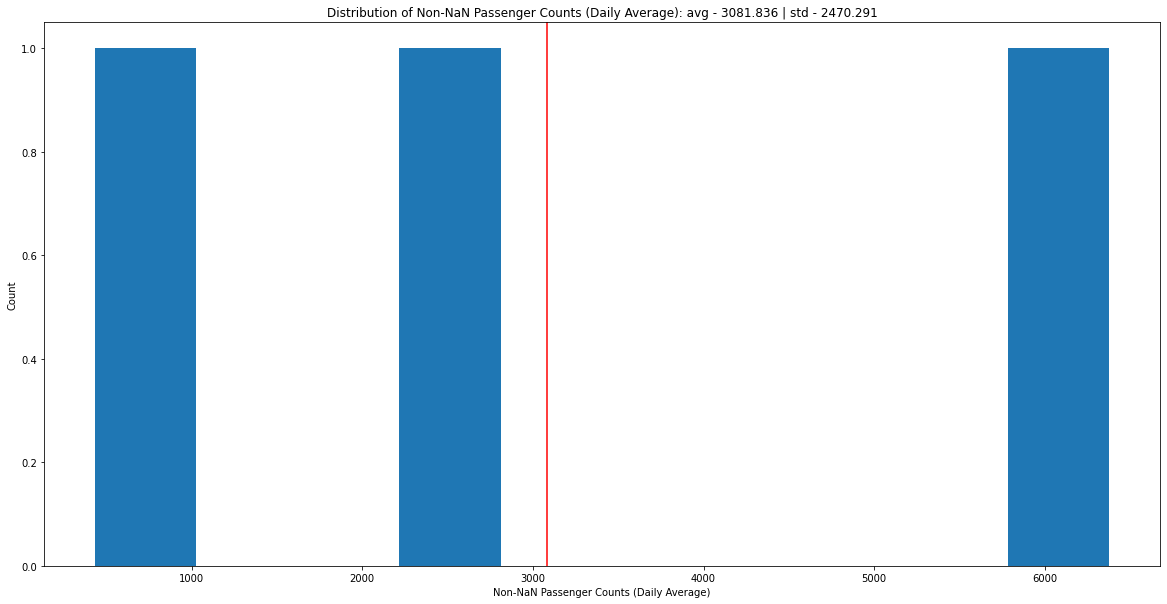

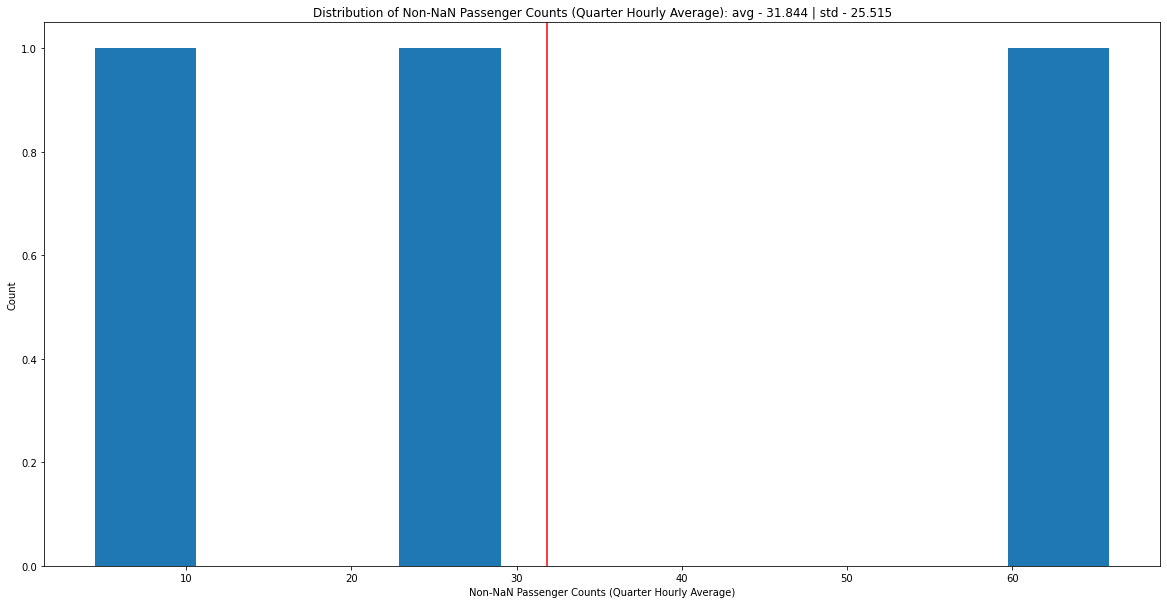

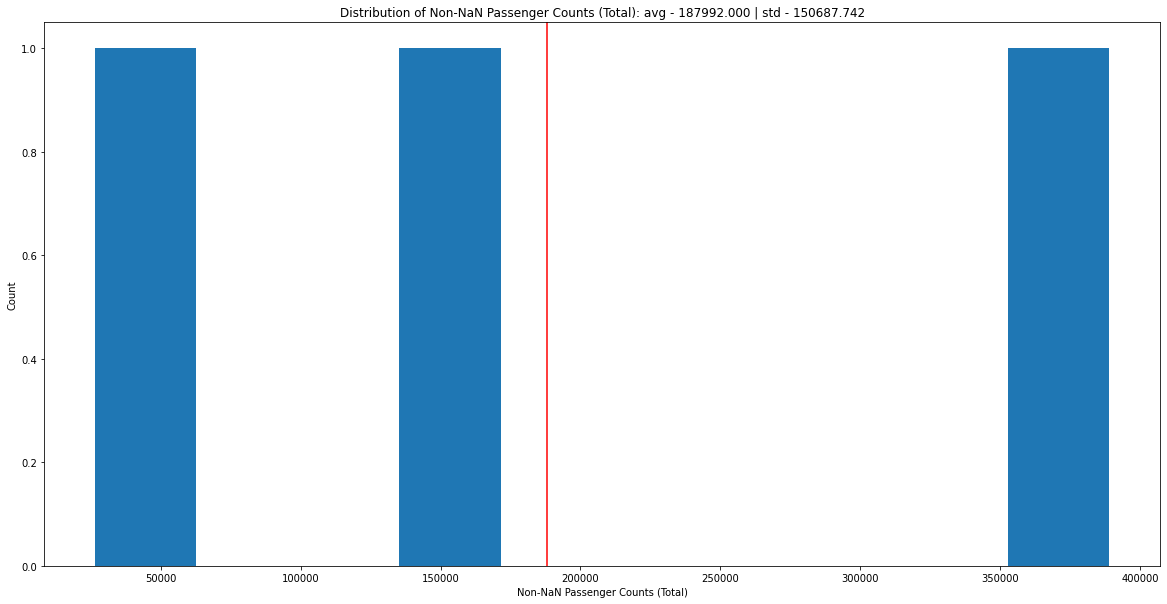

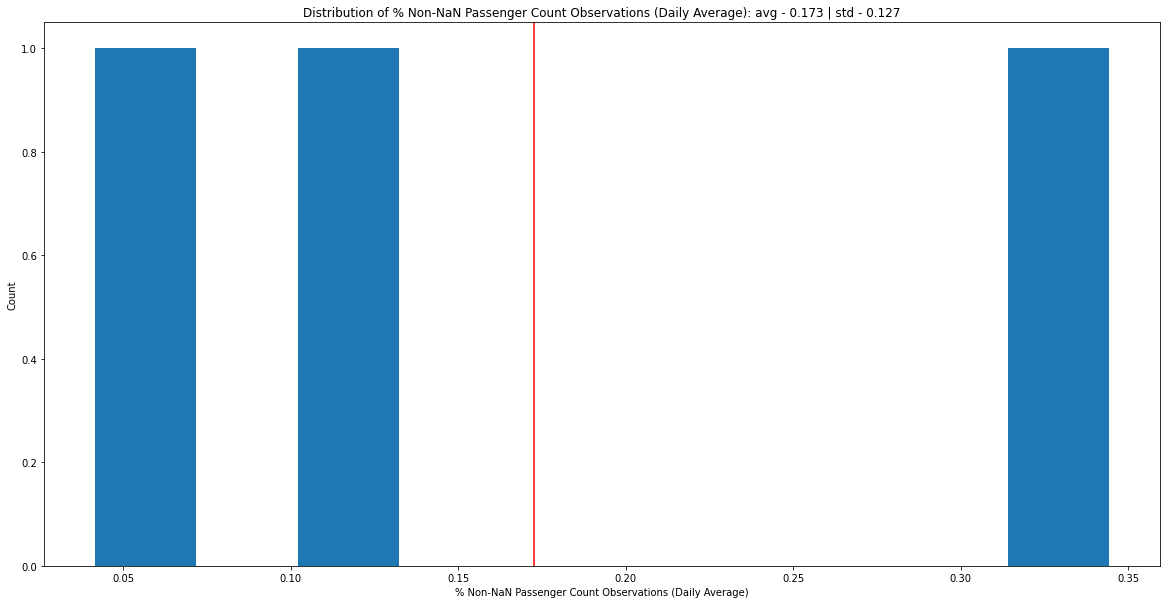

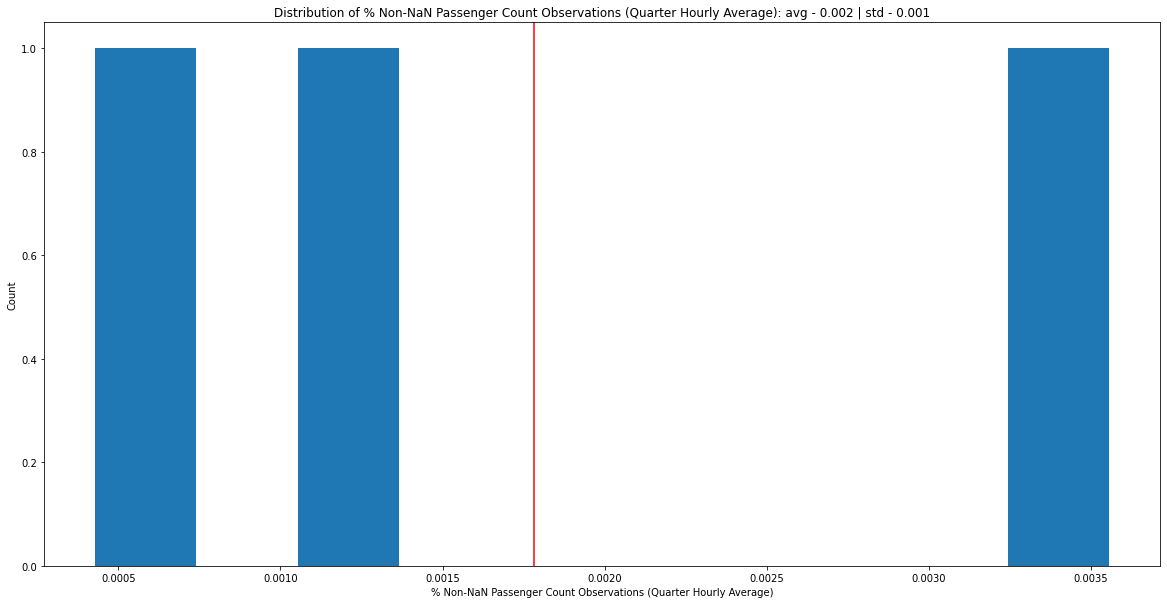

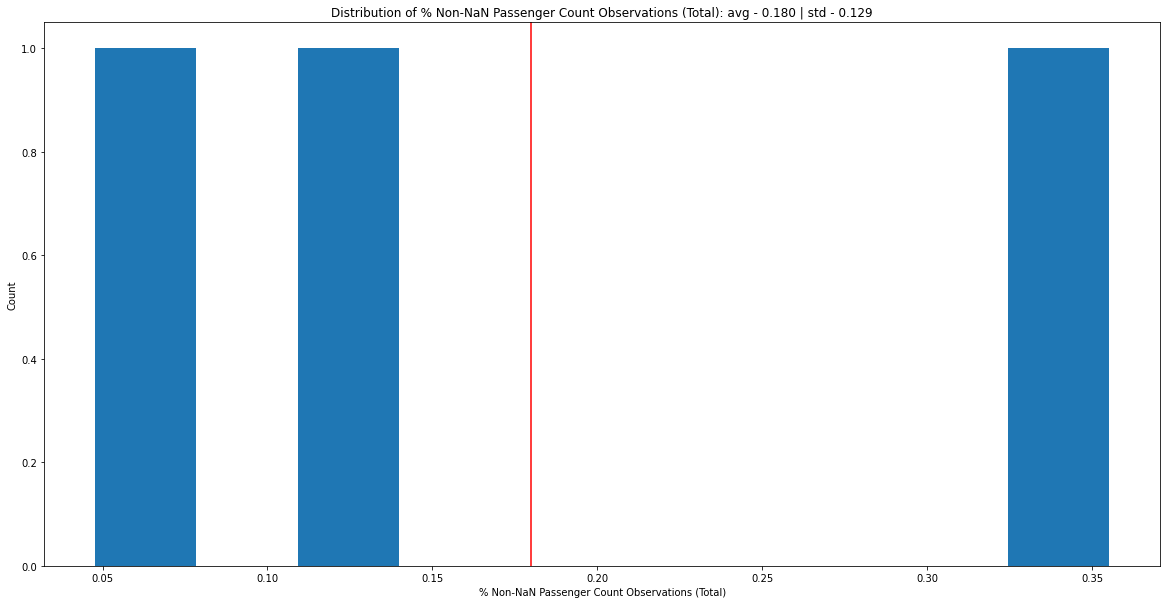

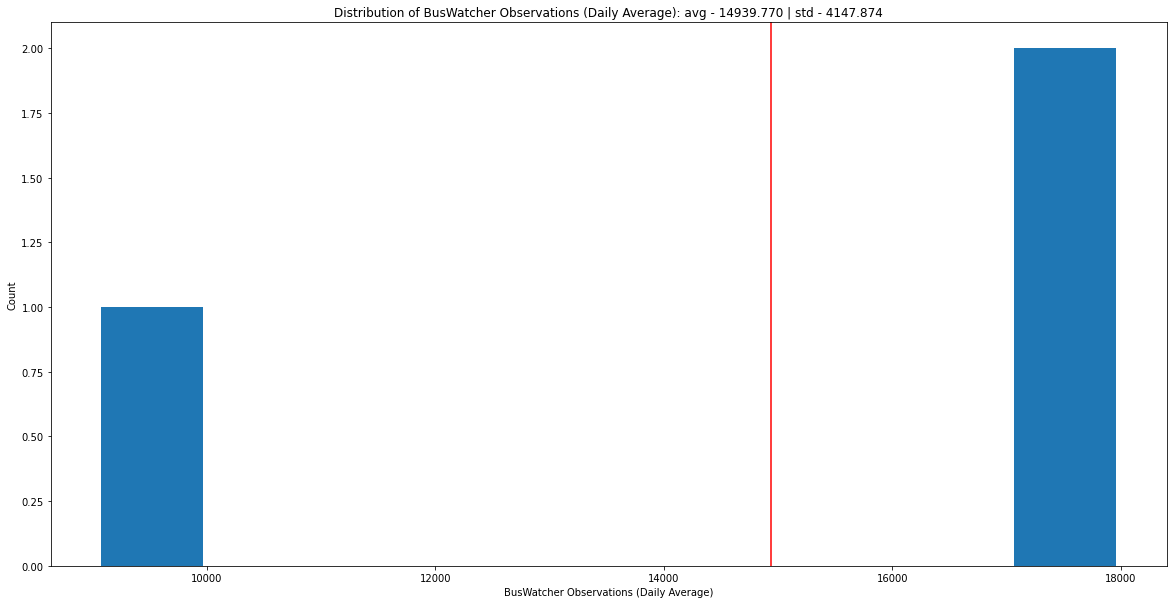

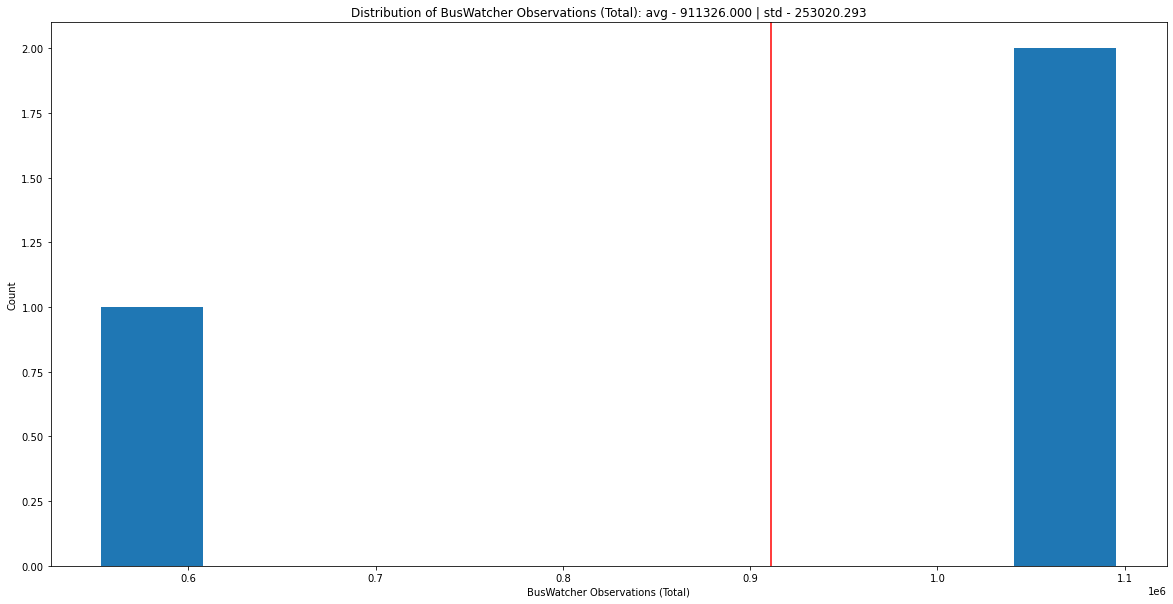

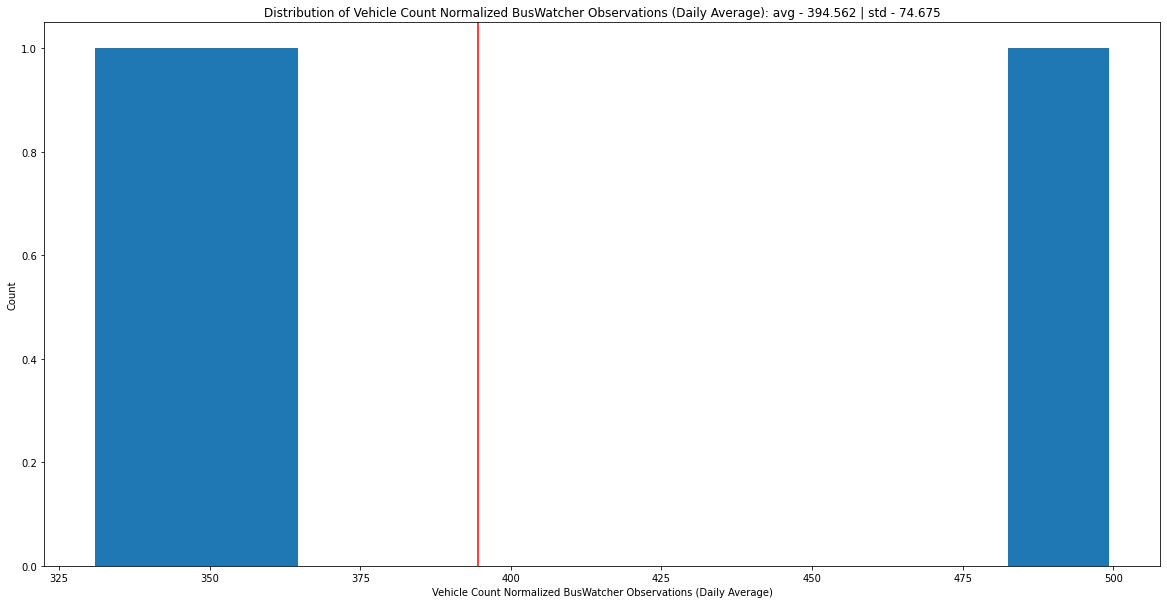

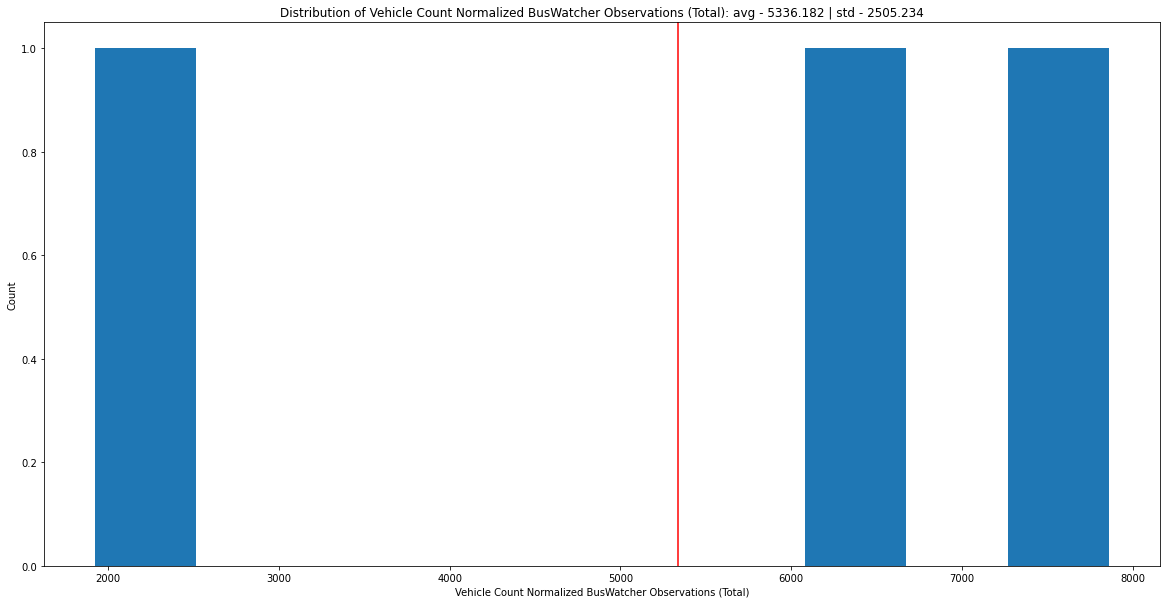

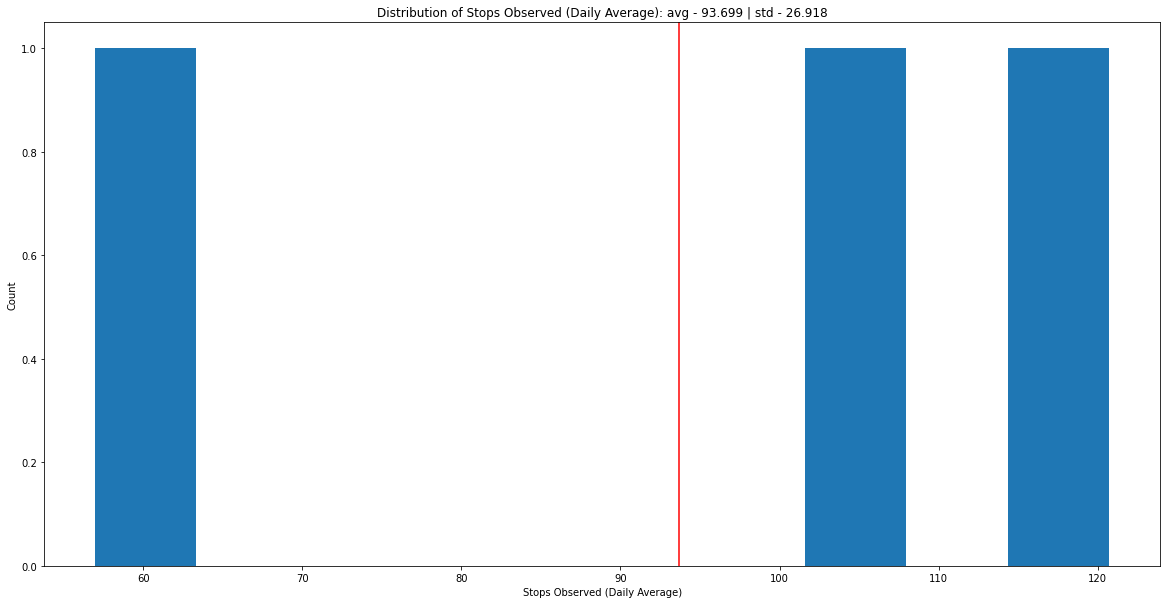

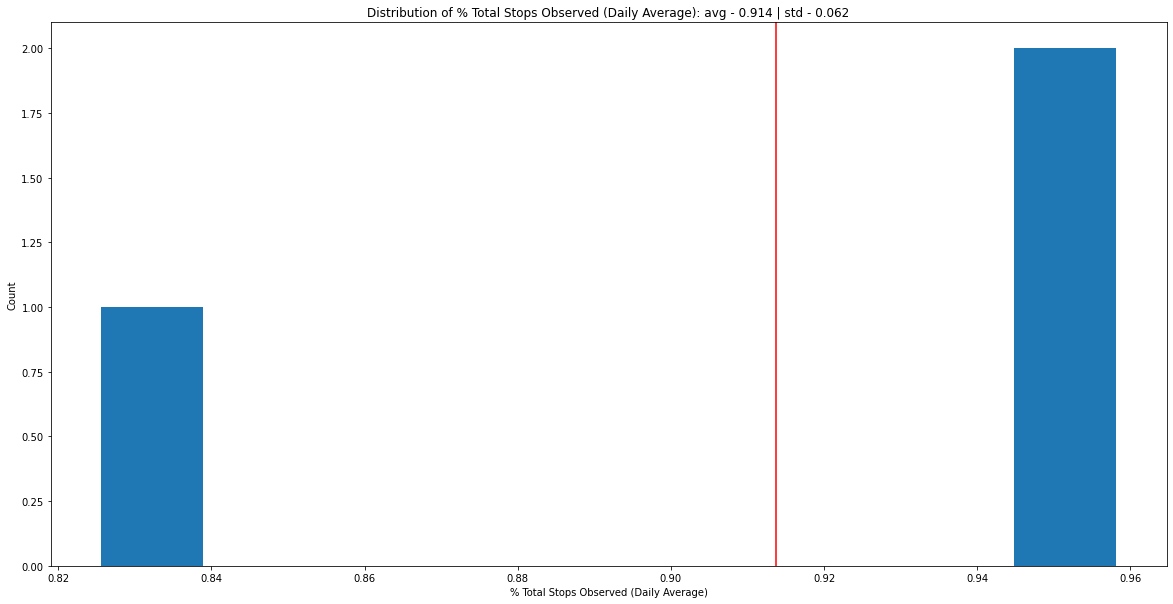

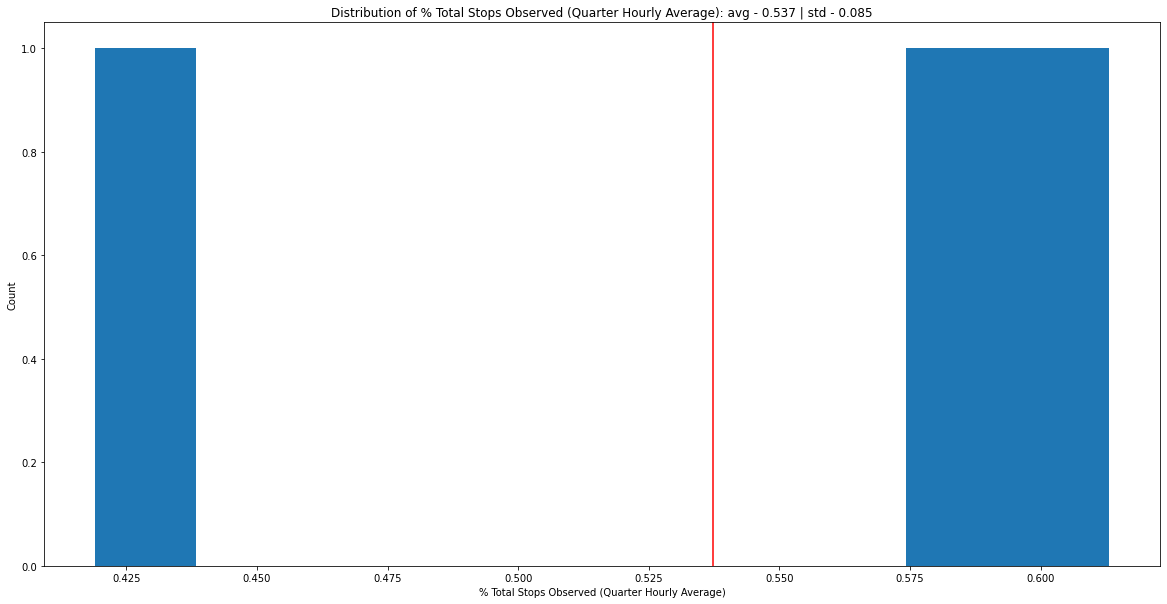

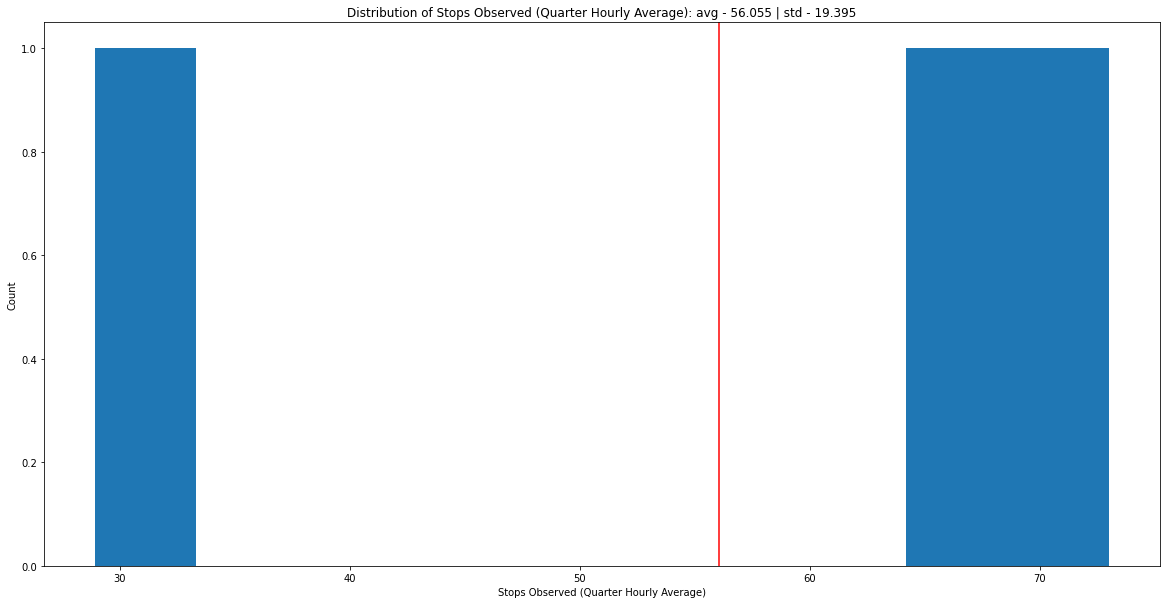

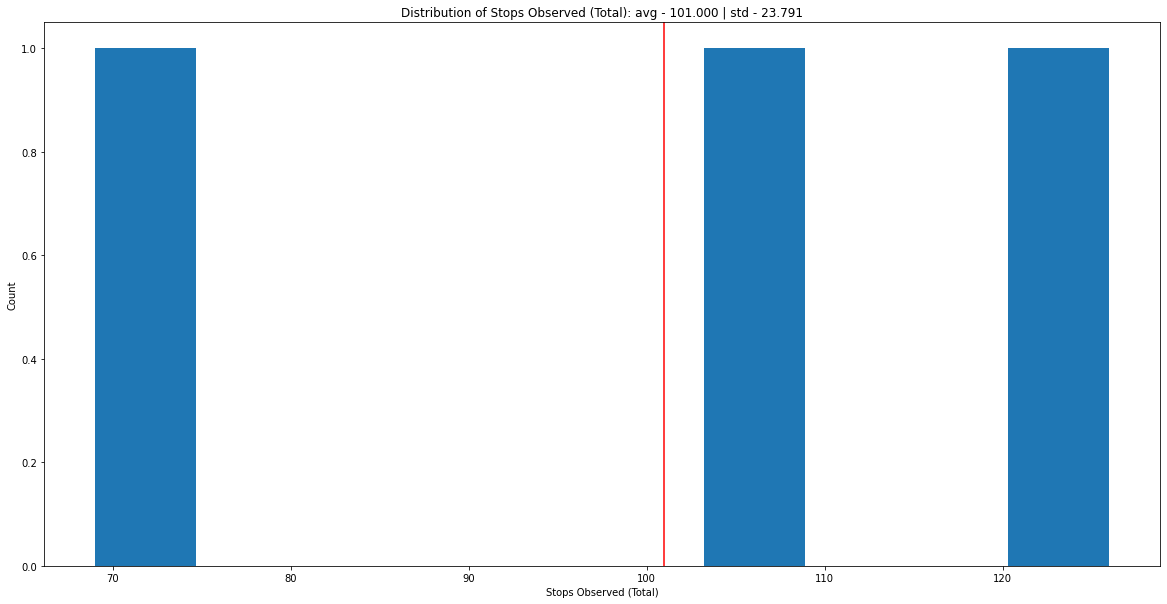

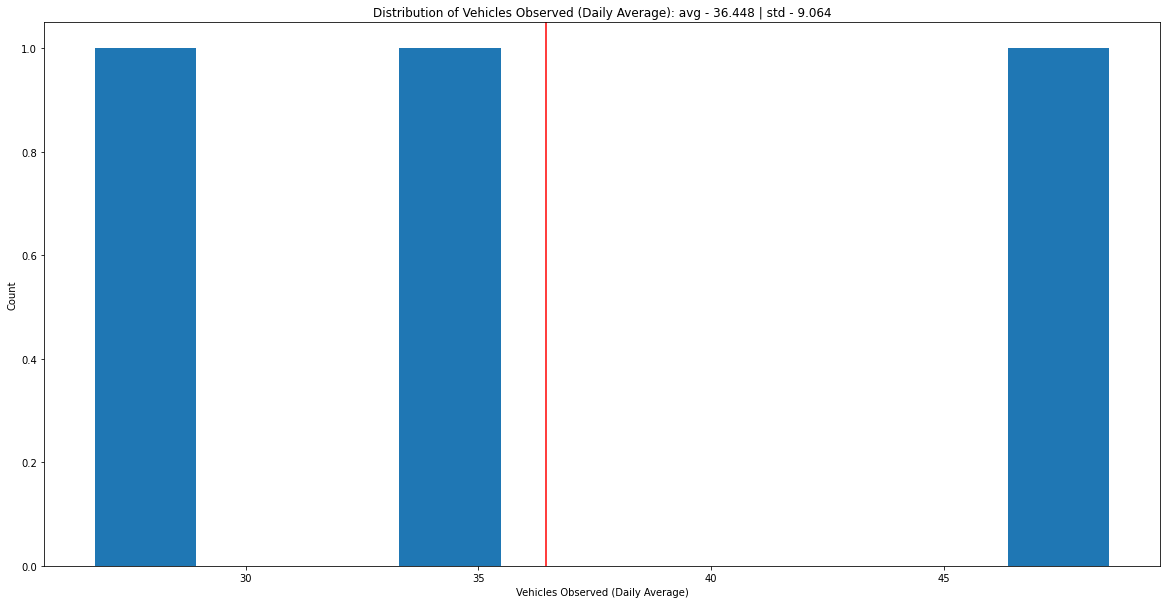

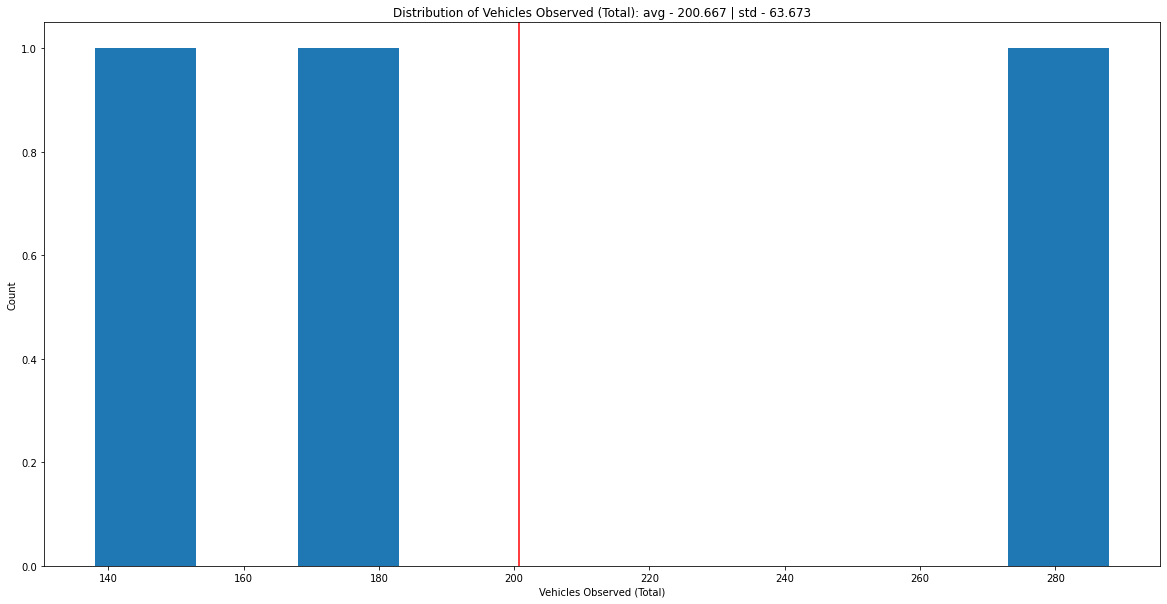

In [ ]:
xlabels_route = {
    'obs:gros:total':'BusWatcher Observations (Total)',
    'obs:gros:daily:avg':'BusWatcher Observations (Daily Average)',
    'obs:norm/vhcls:total':'Vehicle Count Normalized BusWatcher Observations (Total)',
    'obs:norm/vhcls:daily:avg':'Vehicle Count Normalized BusWatcher Observations (Daily Average)',
    'stops:total':'Stops Observed (Total)',
    'stops:daily:avg':'Stops Observed (Daily Average)',
    'stops:qh:avg':'Stops Observed (Quarter Hourly Average)',
    'stops:pct/tot_stops:daily:avg':'% Total Stops Observed (Daily Average)',
    'stops:pct/tot_stops:qh:avg':'% Total Stops Observed (Quarter Hourly Average)',
    'vhcls:total':'Vehicles Observed (Total)',
    'vhcls:daily:avg':'Vehicles Observed (Daily Average)',
    'non_nans:gros:total':'Non-NaN Passenger Counts (Total)',
    'non_nans:gros:daily:avg':'Non-NaN Passenger Counts (Daily Average)',
    'non_nans:gros:qh:avg':'Non-NaN Passenger Counts (Quarter Hourly Average)',
    'non_nans:pct/tot_obs:total':'% Non-NaN Passenger Count Observations (Total)',
    'non_nans:pct/tot_obs:daily:avg':'% Non-NaN Passenger Count Observations (Daily Average)',
    'non_nans:pct/tot_obs:qh:avg':'% Non-NaN Passenger Count Observations (Quarter Hourly Average)'
}

make_hists(routes_df, xlabels_route)

## Vehicle Stats

### Compute Stats DataFrame

In [ ]:
vehicles_dict = {}

for vehicle in buswatcher_vehicles:
  vehicle_data = buswatcher_data[buswatcher_data['vehicle_id'] == vehicle]
  
  if vehicle_data.shape[0] != 0:
    vehicle_routes = set(vehicle_data['route'])
    vehicle_stops = set(vehicle_data['next_stop_id'])
    
    num_vehicle_observations = np.float64(vehicle_data.shape[0]) # for handling div0 errors
    num_vehicle_routes = len(vehicle_routes)
    num_vehicle_stops = np.float64(len(vehicle_stops)) # for handling div0 errors
    num_vehicle_non_nan_passenger_counts = vehicle_data['passenger_count'].notna().sum()

    if num_vehicle_non_nan_passenger_counts == 0:
      pct_vehicle_non_nan_passenger_counts = 0
    else:  
      pct_vehicle_non_nan_passenger_counts = num_vehicle_non_nan_passenger_counts / num_vehicle_observations

    daily_num_vehicle_observations = []
    daily_num_vehicle_routes = []
    daily_num_vehicle_stops = []
    daily_num_vehicle_non_nan_passenger_counts = []

    daily_pct_vehicle_stops = []
    daily_pct_vehicle_non_nan_passenger_counts = []

    ####################
    qhly_num_vehicle_stops = []
    qhly_num_vehicle_non_nan_passenger_counts = []

    qhly_pct_vehicle_stops = []
    qhly_pct_vehicle_non_nan_passenger_counts = []
    ####################

    start = vehicle_data.timestamp.min()
    end = vehicle_data.timestamp.max()
    dates = pd.date_range(start=start, end=end)

    for date in dates:
      day_vehicle_data = vehicle_data[vehicle_data['timestamp'].dt.date == date.date()]
      day_vehicle_routes = set(day_vehicle_data['route'])
      day_vehicle_stops = set(day_vehicle_data['next_stop_id'])
      
      day_num_vehicle_observations = np.float64(day_vehicle_data.shape[0]) # for handling div0 errors
      day_num_vehicle_routes = len(day_vehicle_routes)
      day_num_vehicle_stops = len(day_vehicle_stops)
      day_num_vehicle_non_nan_passenger_counts = day_vehicle_data['passenger_count'].notna().sum()

      if day_num_vehicle_stops == 0:
        day_pct_vehicle_stops = 0
      else:  
        day_pct_vehicle_stops = day_num_vehicle_stops / num_vehicle_stops
      if day_num_vehicle_non_nan_passenger_counts == 0:
        day_pct_vehicle_non_nan_passenger_counts = 0
      else:  
        day_pct_vehicle_non_nan_passenger_counts = day_num_vehicle_non_nan_passenger_counts / day_num_vehicle_observations

      daily_num_vehicle_observations.append(day_num_vehicle_observations)
      daily_num_vehicle_routes.append(day_num_vehicle_routes)
      daily_num_vehicle_stops.append(day_num_vehicle_stops)
      daily_num_vehicle_non_nan_passenger_counts.append(day_num_vehicle_non_nan_passenger_counts)

      daily_pct_vehicle_stops.append(day_pct_vehicle_stops)
      daily_pct_vehicle_non_nan_passenger_counts.append(day_pct_vehicle_non_nan_passenger_counts)

      ####################
      for (start, end) in quarter_hour_intervals:
        qh_vehicle_data = day_vehicle_data[(day_vehicle_data['timestamp'].dt.time >= start) & (day_vehicle_data['timestamp'].dt.time < end)]
        qh_vehicle_stops = set(qh_vehicle_data['next_stop_id'])
        
        qh_num_vehicle_stops = len(qh_vehicle_stops)
        qh_num_vehicle_non_nan_passenger_counts = qh_vehicle_data['passenger_count'].notna().sum()

        if qh_num_vehicle_stops == 0:
          qh_pct_vehicle_stops = 0
        else:
          qh_pct_vehicle_stops = qh_num_vehicle_stops / num_vehicle_stops
        if qh_num_vehicle_non_nan_passenger_counts == 0:
          qh_pct_vehicle_non_nan_passenger_counts = 0  
        else:
          qh_pct_vehicle_non_nan_passenger_counts = qh_num_vehicle_non_nan_passenger_counts / day_num_vehicle_observations

        qhly_num_vehicle_stops.append(qh_num_vehicle_stops)
        qhly_num_vehicle_non_nan_passenger_counts.append(qh_num_vehicle_non_nan_passenger_counts)

        qhly_pct_vehicle_stops.append(qh_pct_vehicle_stops)
        qhly_pct_vehicle_non_nan_passenger_counts.append(qh_pct_vehicle_non_nan_passenger_counts)
      ####################

    daily_num_vehicle_observations = np.array(daily_num_vehicle_observations)
    daily_num_vehicle_routes = np.array(daily_num_vehicle_routes)
    daily_num_vehicle_stops = np.array(daily_num_vehicle_stops)
    daily_num_vehicle_non_nan_passenger_counts = np.array(daily_num_vehicle_non_nan_passenger_counts)

    daily_pct_vehicle_stops = np.array(daily_pct_vehicle_stops)
    daily_pct_vehicle_non_nan_passenger_counts = np.array(daily_pct_vehicle_non_nan_passenger_counts)

    ####################
    qhly_num_vehicle_stops = np.array(qhly_num_vehicle_stops)
    qhly_num_vehicle_non_nan_passenger_counts = np.array(qhly_num_vehicle_non_nan_passenger_counts)

    qhly_pct_vehicle_stops = np.array(qhly_pct_vehicle_stops)
    qhly_pct_vehicle_non_nan_passenger_counts = np.array(qhly_pct_vehicle_non_nan_passenger_counts)
    ####################

    vehicles_dict[vehicle] = {
        'obs:gros:total':num_vehicle_observations,
        'obs:gros:daily:avg':daily_num_vehicle_observations.mean(),
        'obs:gros:daily:std':daily_num_vehicle_observations.std(),
        'routes:total':num_vehicle_routes,
        'routes:daily:avg':daily_num_vehicle_routes.mean(),
        'routes:daily:std':daily_num_vehicle_routes.std(),
        'stops:total':num_vehicle_stops,
        'stops:daily:avg':daily_num_vehicle_stops.mean(),
        'stops:daily:std':daily_num_vehicle_stops.std(),
        'stops:pct/tot_stops:daily:avg':daily_pct_vehicle_stops.mean(),
        'stops:pct/tot_stops:daily:std':daily_pct_vehicle_stops.std(),
        
        ####################
        'stops:qh:avg':qhly_num_vehicle_stops.mean(),
        'stops:qh:std':qhly_num_vehicle_stops.std(),
        'stops:pct/tot_stops:qh:avg':qhly_pct_vehicle_stops.mean(),
        'stops:pct/tot_stops:qh:std':qhly_pct_vehicle_stops.std(),
        ####################

        'non_nans:gros:total':num_vehicle_non_nan_passenger_counts,
        'non_nans:gros:daily:avg':daily_num_vehicle_non_nan_passenger_counts.mean(),
        'non_nans:gros:daily:std':daily_num_vehicle_non_nan_passenger_counts.std(),

        ####################
        'non_nans:gros:qh:avg':qhly_num_vehicle_non_nan_passenger_counts.mean(),
        'non_nans:gros:qh:std':qhly_num_vehicle_non_nan_passenger_counts.std(),
        ####################
        
        'non_nans:pct/tot_obs:total':pct_vehicle_non_nan_passenger_counts,
        'non_nans:pct/tot_obs:daily:avg':daily_pct_vehicle_non_nan_passenger_counts.mean(),
        'non_nans:pct/tot_obs:daily:std':daily_pct_vehicle_non_nan_passenger_counts.std(),

        ####################
        'non_nans:pct/tot_obs:qh:avg':qhly_pct_vehicle_non_nan_passenger_counts.mean(),
        'non_nans:pct/tot_obs:qh:std':qhly_pct_vehicle_non_nan_passenger_counts.std()
        ####################
    }

vehicles_df = pd.DataFrame.from_dict(vehicles_dict, orient='index')
assert vehicles_df.shape[0] == len(buswatcher_vehicles)
vehicles_df.shape

(602, 25)

In [ ]:
# save to drive
vehicles_df.to_csv('/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Bus/API Call/M15_BX12_B46_vehicles.csv')

### Plot Histograms

In [ ]:
# read from drive
vehicles_df = pd.read_csv('/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Bus/API Call/M15_BX12_B46_vehicles.csv', index_col='Unnamed: 0')

In [ ]:
vehicles_df.head()

,obs:gros:total,obs:gros:daily:avg,obs:gros:daily:std,routes:total,routes:daily:avg,routes:daily:std,stops:total,stops:daily:avg,stops:daily:std,stops:pct/tot_stops:daily:avg,stops:pct/tot_stops:daily:std,stops:qh:avg,stops:qh:std,stops:pct/tot_stops:qh:avg,stops:pct/tot_stops:qh:std,non_nans:gros:total,non_nans:gros:daily:avg,non_nans:gros:daily:std,non_nans:gros:qh:avg,non_nans:gros:qh:std,non_nans:pct/tot_obs:total,non_nans:pct/tot_obs:daily:avg,non_nans:pct/tot_obs:daily:std,non_nans:pct/tot_obs:qh:avg,non_nans:pct/tot_obs:qh:std
MTA NYCT_7313,8887.0,145.688525,269.292062,1,0.442623,0.496697,107.0,33.459016,42.736161,0.312701,0.399403,0.901298,2.744809,0.008423,0.025652,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MTA NYCT_5532,118.0,1.833333,9.822027,1,0.074074,0.261891,32.0,0.425926,2.454036,0.013310,0.076689,0.008488,0.222927,0.000265,0.006966,99,1.555556,8.729827,0.016204,0.426875,0.838983,0.066519,0.238118,0.000693,0.021387
MTA NYCT_7656,3485.0,105.606061,228.434984,1,0.303030,0.459568,106.0,23.757576,38.752541,0.224128,0.365590,0.625316,2.322638,0.005899,0.021912,3006,91.090909,202.478486,0.934659,3.452120,0.862554,0.252948,0.384474,0.002610,0.013758
MTA NYCT_1249,180.0,180.000000,0.000000,1,1.000000,0.000000,8.0,8.000000,0.000000,1.000000,0.000000,0.416667,1.047484,0.052083,0.130935,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MTA NYCT_5930,3019.0,49.491803,160.514197,1,0.163934,0.370216,60.0,6.655738,15.979377,0.110929,0.266323,0.231557,1.196535,0.003859,0.019942,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


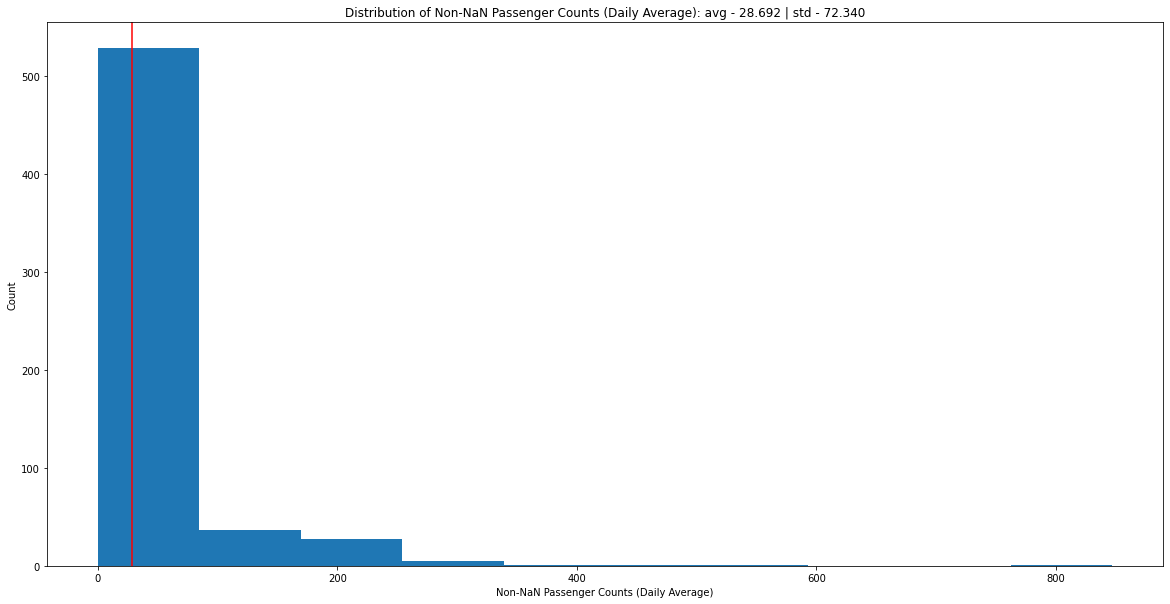

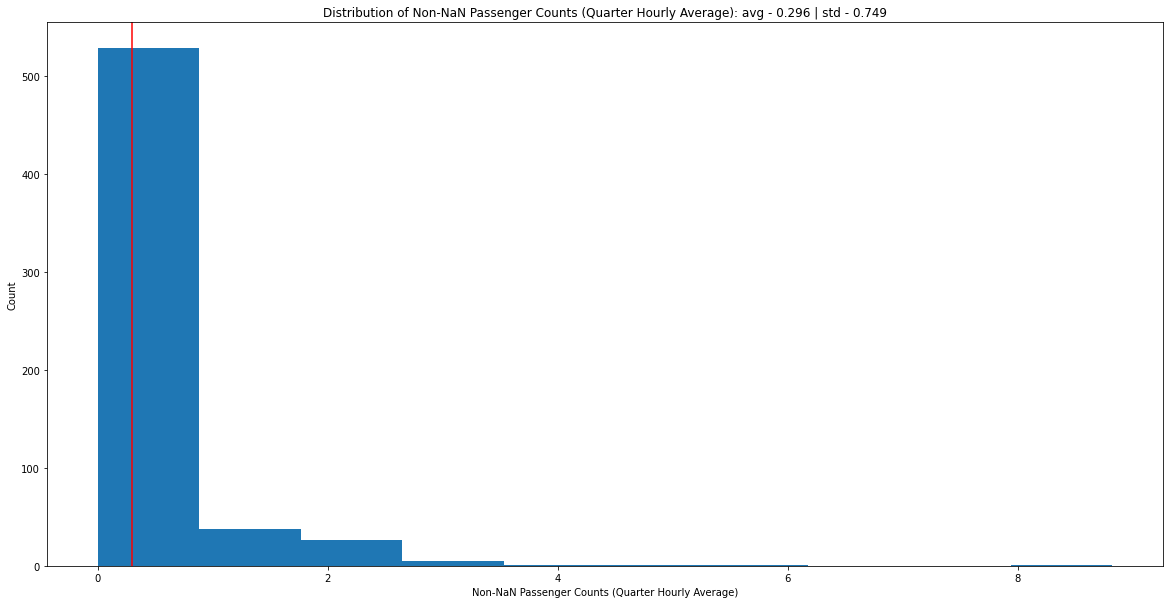

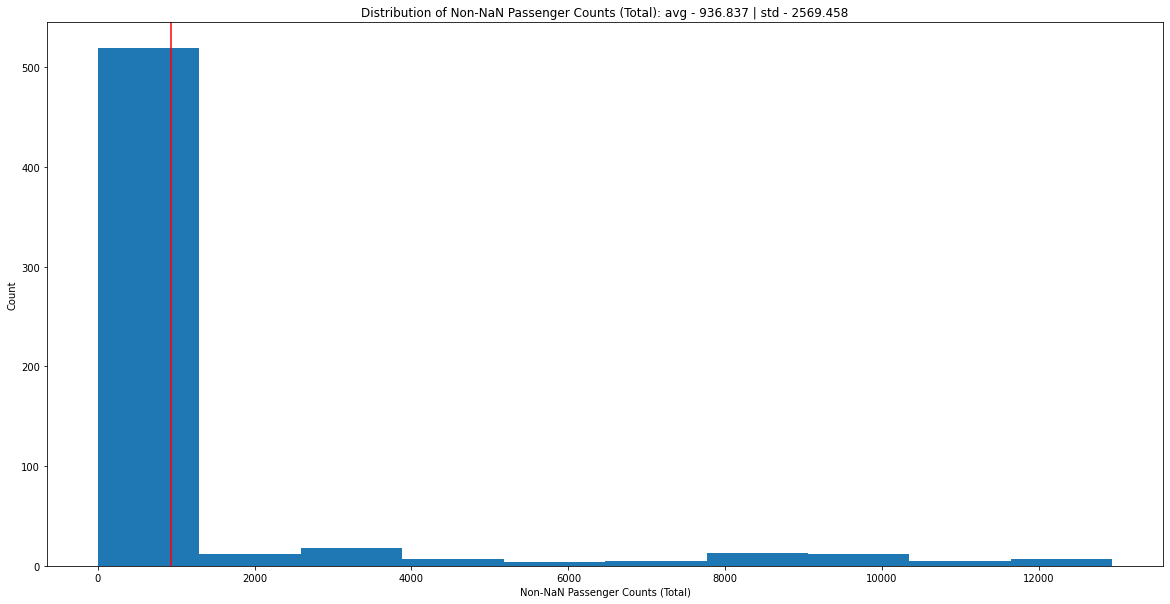

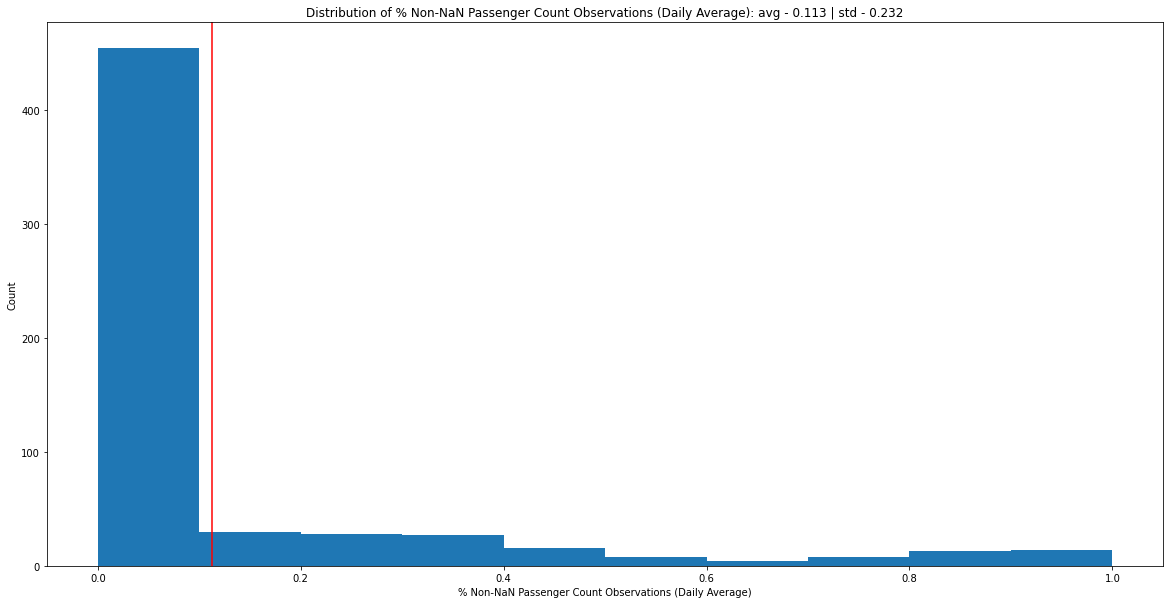

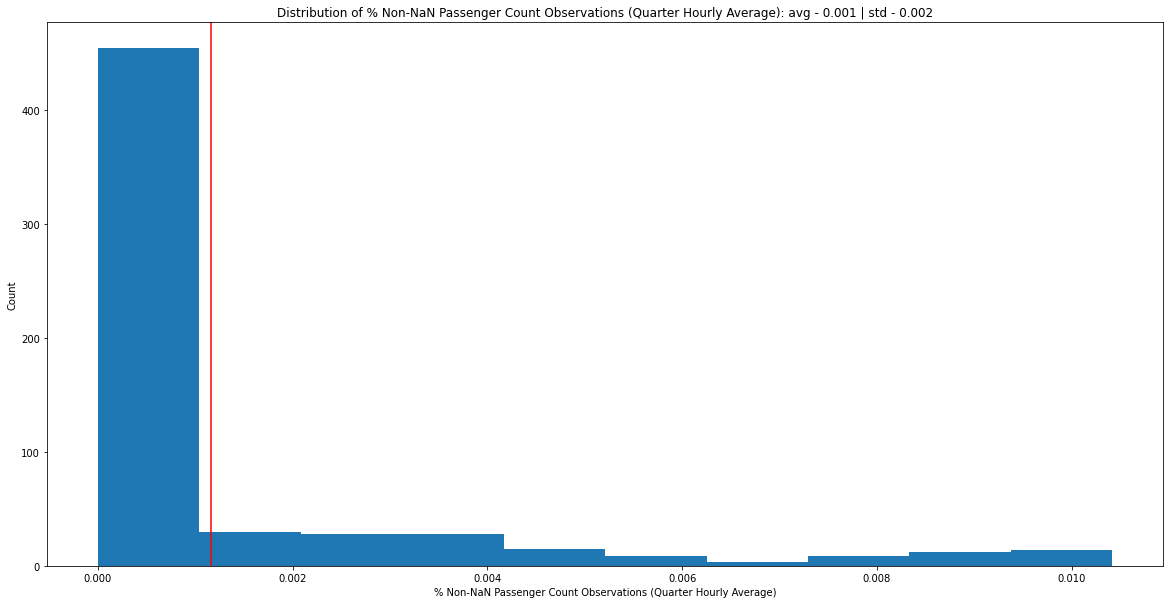

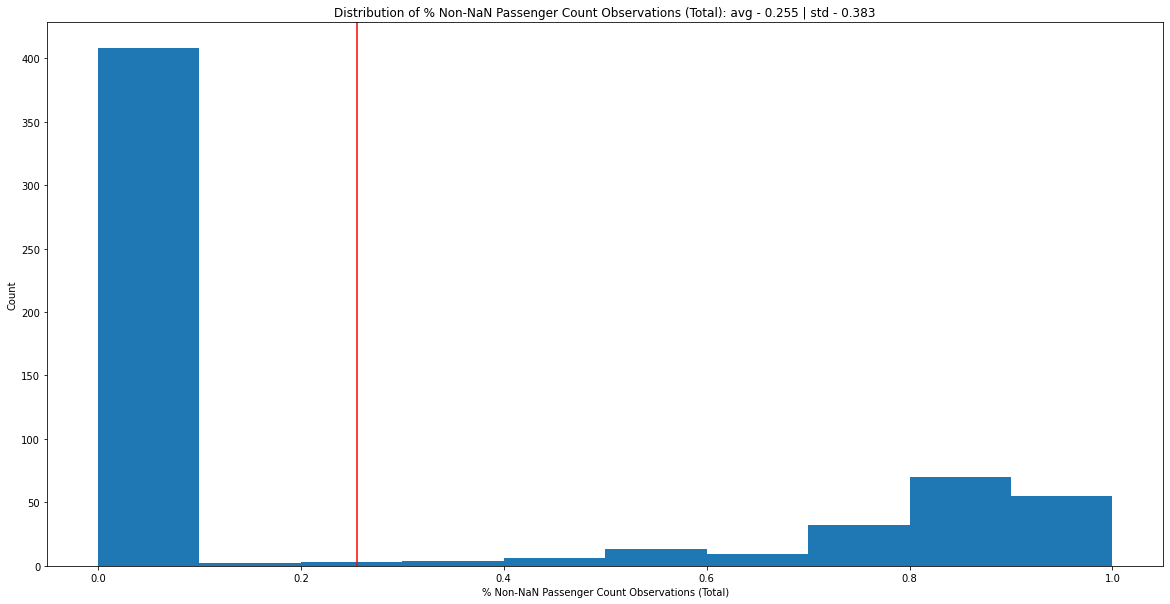

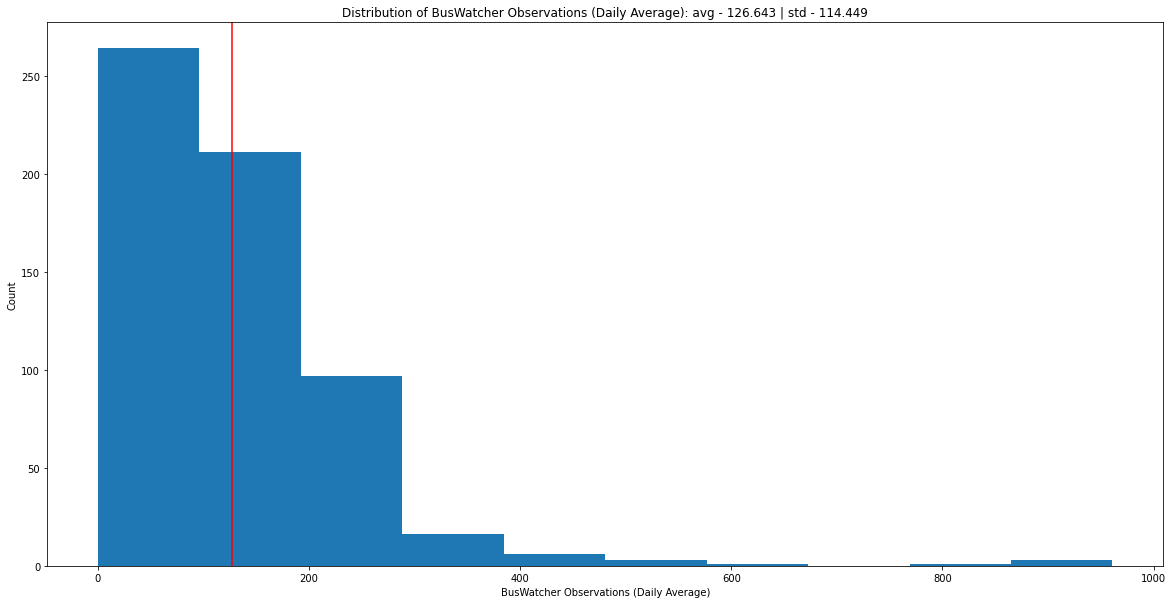

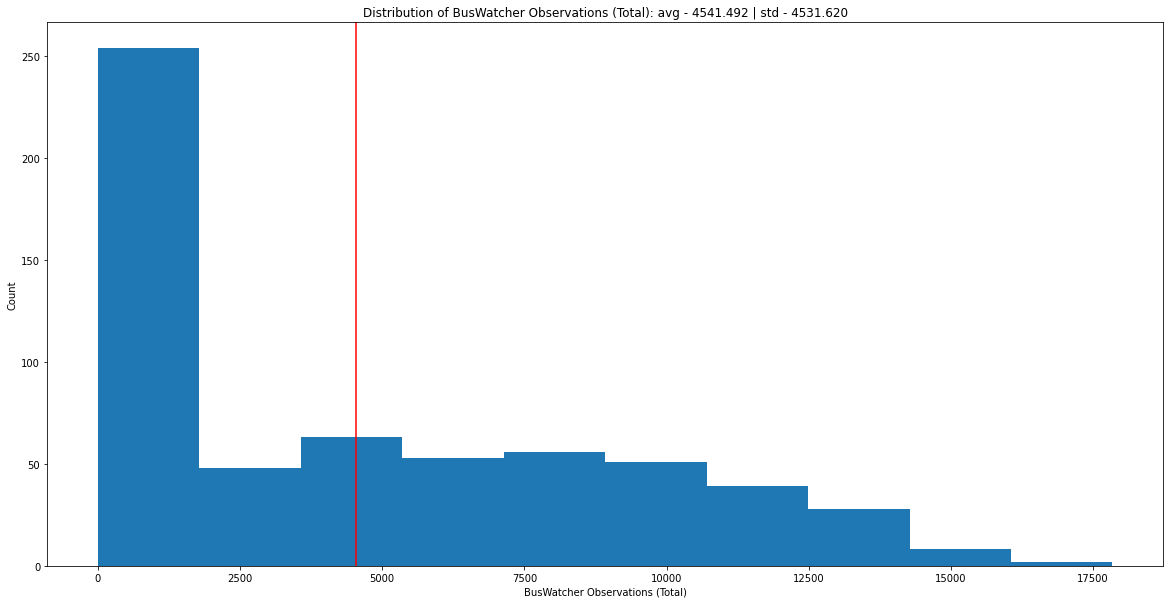

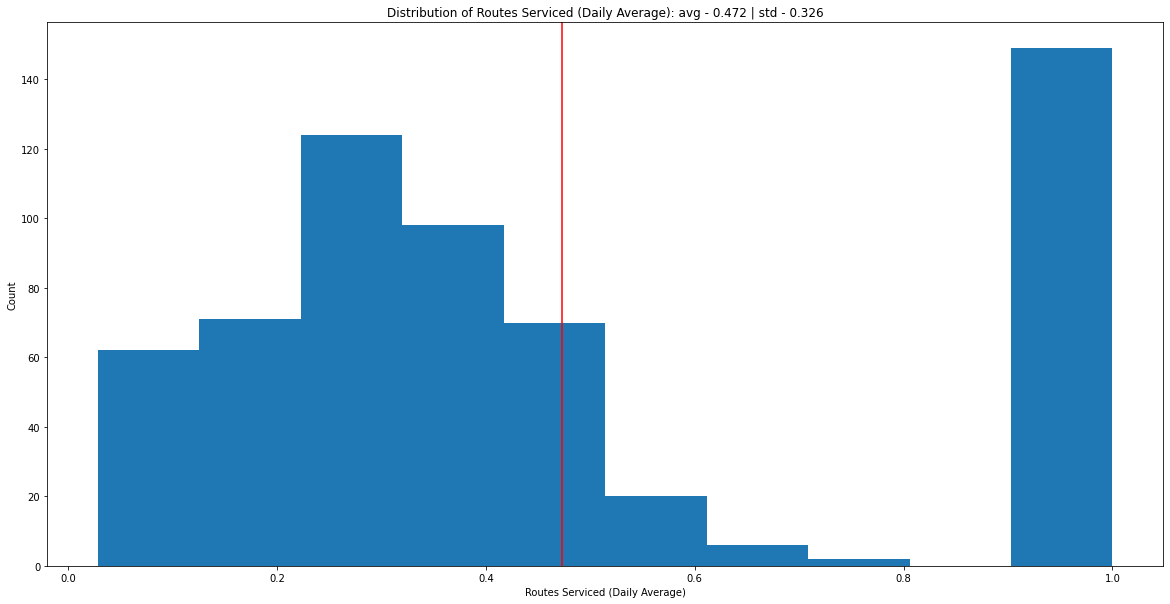

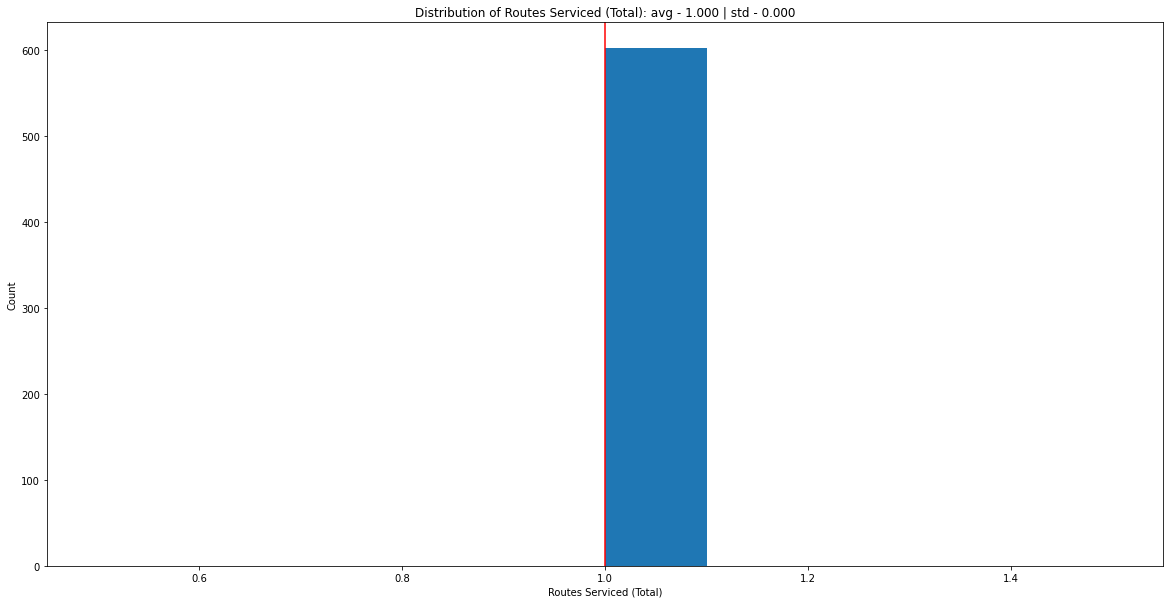

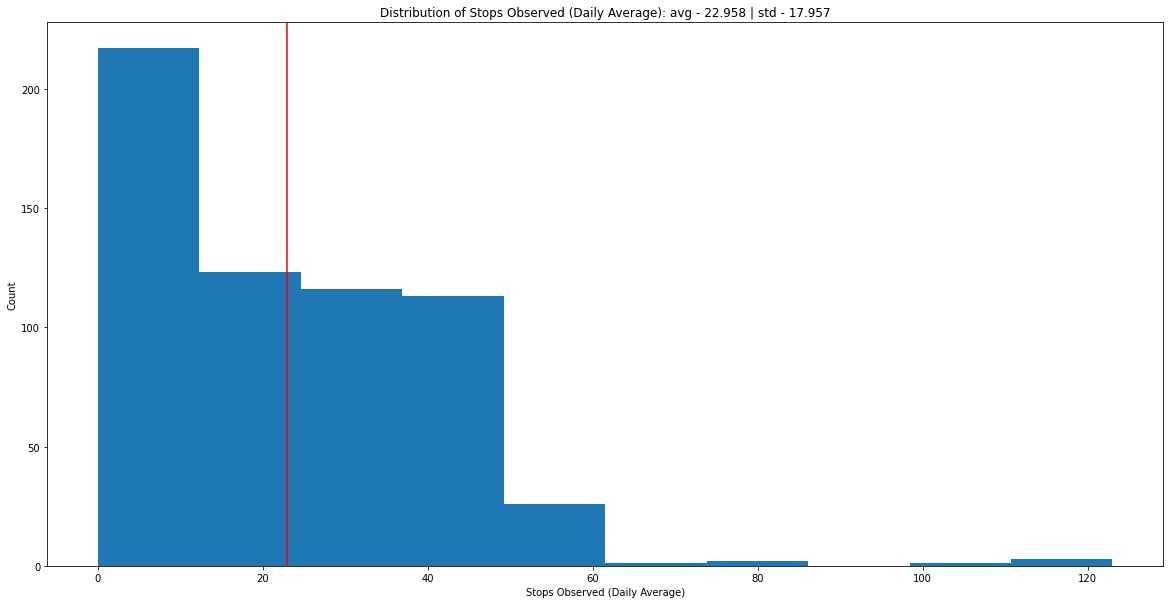

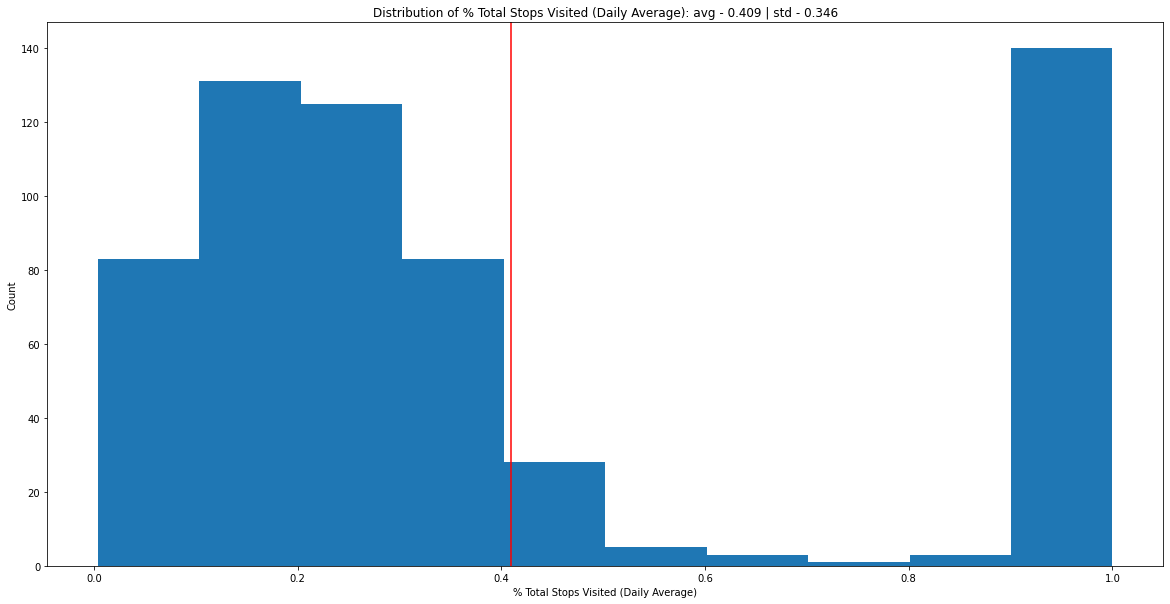

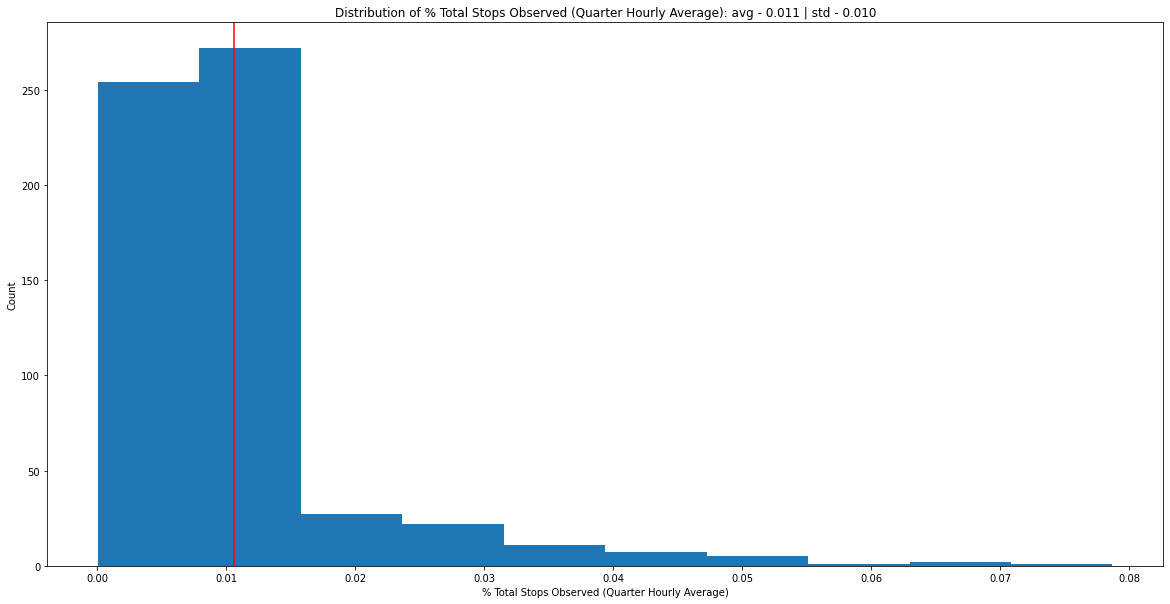

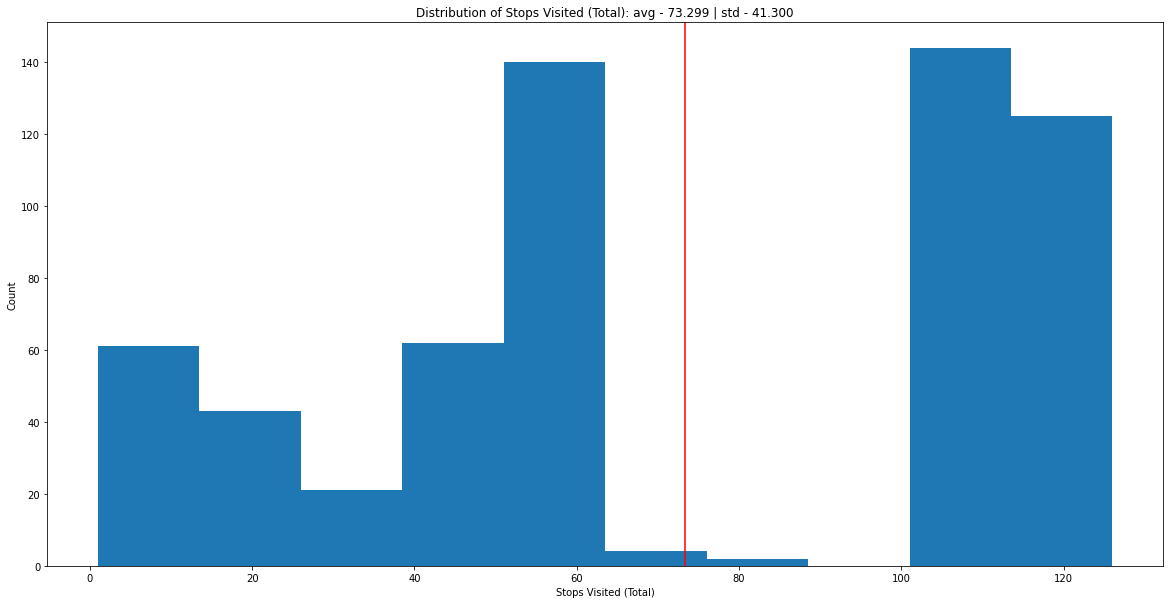

In [ ]:
xlabels_vehicle = {
    'obs:gros:total':'BusWatcher Observations (Total)',
    'obs:gros:daily:avg':'BusWatcher Observations (Daily Average)',
    'routes:total':'Routes Serviced (Total)',
    'routes:daily:avg':'Routes Serviced (Daily Average)',
    'stops:total':'Stops Visited (Total)',
    'stops:daily:avg':'Stops Visited (Daily Average)',
    'stops:daily:avg':'Stops Observed (Daily Average)',
    'stops:pct/tot_stops:daily:avg':'% Total Stops Visited (Daily Average)',
    'stops:pct/tot_stops:qh:avg':'% Total Stops Observed (Quarter Hourly Average)',
    'non_nans:gros:total':'Non-NaN Passenger Counts (Total)',
    'non_nans:gros:daily:avg':'Non-NaN Passenger Counts (Daily Average)',
    'non_nans:gros:qh:avg':'Non-NaN Passenger Counts (Quarter Hourly Average)',
    'non_nans:pct/tot_obs:total':'% Non-NaN Passenger Count Observations (Total)',
    'non_nans:pct/tot_obs:daily:avg':'% Non-NaN Passenger Count Observations (Daily Average)',
    'non_nans:pct/tot_obs:qh:avg':'% Non-NaN Passenger Count Observations (Quarter Hourly Average)'
}

make_hists(vehicles_df, xlabels_vehicle)

In [ ]:
vehicles_df

,obs:gros:total,obs:gros:daily:avg,obs:gros:daily:std,routes:total,routes:daily:avg,routes:daily:std,stops:total,stops:daily:avg,stops:daily:std,stops:pct/tot_stops:daily:avg,stops:pct/tot_stops:daily:std,stops:qh:avg,stops:qh:std,stops:pct/tot_stops:qh:avg,stops:pct/tot_stops:qh:std,non_nans:gros:total,non_nans:gros:daily:avg,non_nans:gros:daily:std,non_nans:gros:qh:avg,non_nans:gros:qh:std,non_nans:pct/tot_obs:total,non_nans:pct/tot_obs:daily:avg,non_nans:pct/tot_obs:daily:std,non_nans:pct/tot_obs:qh:avg,non_nans:pct/tot_obs:qh:std
MTA NYCT_7313,8887.0,145.688525,269.292062,1,0.442623,0.496697,107.0,33.459016,42.736161,0.312701,0.399403,0.901298,2.744809,0.008423,0.025652,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MTA NYCT_5532,118.0,1.833333,9.822027,1,0.074074,0.261891,32.0,0.425926,2.454036,0.013310,0.076689,0.008488,0.222927,0.000265,0.006966,99,1.555556,8.729827,0.016204,0.426875,0.838983,0.066519,0.238118,0.000693,0.021387
MTA NYCT_7656,3485.0,105.606061,228.434984,1,0.303030,0.459568,106.0,23.757576,38.752541,0.224128,0.365590,0.625316,2.322638,0.005899,0.021912,3006,91.090909,202.478486,0.934659,3.452120,0.862554,0.252948,0.384474,0.002610,0.013758
MTA NYCT_1249,180.0,180.000000,0.000000,1,1.000000,0.000000,8.0,8.000000,0.000000,1.000000,0.000000,0.416667,1.047484,0.052083,0.130935,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MTA NYCT_5930,3019.0,49.491803,160.514197,1,0.163934,0.370216,60.0,6.655738,15.979377,0.110929,0.266323,0.231557,1.196535,0.003859,0.019942,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MTA NYCT_1262,4979.0,95.750000,224.501488,1,0.269231,0.443560,61.0,10.615385,19.806908,0.174023,0.324703,0.476162,1.786095,0.007806,0.029280,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MTA NYCT_6045,6542.0,107.245902,258.014147,1,0.245902,0.430621,124.0,19.245902,39.950648,0.155209,0.322183,0.590164,2.150518,0.004759,0.017343,5004,82.032787,216.322389,0.851434,3.322303,0.764904,0.173251,0.339377,0.001765,0.013043
MTA NYCT_8351,168.0,7.304348,18.583384,1,0.173913,0.379035,43.0,2.652174,7.805286,0.061678,0.181518,0.036232,0.494124,0.000843,0.011491,96,4.173913,10.861388,0.043478,0.705127,0.571429,0.082181,0.220773,0.000856,0.014848
MTA NYCT_6067,11590.0,203.333333,352.907837,1,0.350877,0.477245,125.0,35.245614,50.584749,0.281965,0.404678,1.144006,2.960526,0.009152,0.023684,10761,188.789474,328.591024,1.958699,4.902236,0.928473,0.318969,0.442069,0.003310,0.013453


## Select Routes for Modeling

In [ ]:
# # guiding principles / thought process behind sort order:
# # want as many non-NaN PC observations as possible
# # want as many non-NaN PC observations per day as possible
# # is it important what % of total observations / daily observations are non-NaN?
# # -> in a perfect world, would have many non-NaN observations AND high non-NaN observation % total observations
# # -> (1) if many non-NaN observations and low non-NaN observation % total observations, then route trafficked by many PC sensor-carrying vehicles but even more non-PC sensor-carrying vehicles
# # -> sensor-carrying vehicles only "observe" a small portion of route's overall ridership, implying potentially non-representative samples / high variance observations
# # -> (2) if few non-NaN observations and high non-NaN observations % total observations (50%+), then route trafficked mostly by PC sensor-carrying vehicles
# # -> sensor-carrying vehicles observe majority of ridership, implying potentially more-representative samples / lower variance
# # -> based on limited data exploration so far, case (2) unrealistic...
# # => prioritize number of non-NaN observations and (TODO) revisit once have data
# # want cosistent number of non-NaN PC observations per day (ideally evenly spread throughout the day)
# # want good route coverage per day (i.e. high % of total route stops visited each day)
# # taking this a step further, want good route coverage per 15 minute interval per day

# # routes_df columns in order of importance to prediction task (most important -> least important) / sort order (ascending={True, False}):
# # non_nans:gros:total / False
# # non_nans:gros:daily:avg / False
# # non_nans:gros:daily:std /  True
# # non_nans:pct/tot_obs:daily:avg / False 
# # stops:pct/tot_stops:daily:avg / False
# # stops:pct/tot_stops:daily:std / True
# # stops:pct/tot_stops:qh:avg / False
# # stops:pct/tot_stops:qh:std / True

# # define sort order
# by = ['non_nans:gros:total','non_nans:gros:daily:avg', 'non_nans:gros:daily:std', 'non_nans:pct/tot_obs:daily:avg', 'stops:pct/tot_stops:daily:avg', 'stops:pct/tot_stops:daily:std', 'stops:pct/tot_stops:qh:avg', 'stops:pct/tot_stops:qh:std']
# ascending = (False, False, True, False, False, True, False, True)

In [ ]:
# # select n "highest-quality" routes per heuristics detailed above
# n = 10
# routes_for_modeling = list(routes_df.sort_values(by=by, ascending=ascending).index)[:n]

# select all routes
routes_for_modeling = routes.copy()

# filter buswatcher_data for highest-quality routes
buswatcher_data_for_modeling = buswatcher_data[buswatcher_data['route'].isin(routes_for_modeling)]

buswatcher_data_for_modeling.shape[0]

2733978

In [ ]:
# remove vehicles with no passenger_count readings
vehicles_for_modeling = set(buswatcher_data_for_modeling['vehicle_id'])
for vehicle in vehicles_for_modeling:
  vehicle_data = buswatcher_data_for_modeling[buswatcher_data_for_modeling['vehicle_id'] == vehicle]
  num_non_nan_passenger_counts = vehicle_data['passenger_count'].notna().sum() 
  if num_non_nan_passenger_counts == 0:
    buswatcher_data_for_modeling = buswatcher_data_for_modeling[buswatcher_data_for_modeling['vehicle_id'] != vehicle]
  
buswatcher_data_for_modeling.shape[0]

656713

In [ ]:
# compute max number of consecutive NaN values in passenger_count (all observations)
max_consecutive_passenger_count_id_NaNs = {}
max_consecutive_passenger_count_id_NaNs_pct = {}

vehicles_for_modeling = set(buswatcher_data_for_modeling['vehicle_id'])

for vehicle in vehicles_for_modeling:
  vehicle_data = buswatcher_data_for_modeling[buswatcher_data_for_modeling['vehicle_id'] == vehicle]
  vehicle_passenger_counts = vehicle_data['passenger_count']
  NaN_groups = vehicle_passenger_counts.notna().cumsum()[vehicle_passenger_counts.isna()]
  lengths_consecutive_NaN = NaN_groups.groupby(NaN_groups).agg(len)
  longest_NaN_group = lengths_consecutive_NaN.max()
  if np.isnan(longest_NaN_group):
    longest_NaN_group = 0
  max_consecutive_passenger_count_id_NaNs[vehicle] = longest_NaN_group

longest_NaN_group = max(max_consecutive_passenger_count_id_NaNs.values())
print(f'longest stretch of NaN passenger_count values is {longest_NaN_group / 60:.1f} consecutive minutes')

longest stretch of NaN passenger_count values is 29.1 consecutive minutes


In [ ]:
# replace NaN passenger_count values with 0 since consecutive stretches of missing data only amout to a maximum of ~30 minutes
buswatcher_data_for_modeling['passenger_count'] = buswatcher_data_for_modeling['passenger_count'].fillna(0)

In [ ]:
buswatcher_data_for_modeling.isna().sum()

index              0
route              0
timestamp          0
next_stop_id       0
vehicle_id         0
passenger_count    0
dtype: int64

## Route Analysis

In [ ]:
def analyze_route(data, target_route):
  target_df = data[data['route'] == target_route]
  others_df = data[data['route'] != target_route]

  pc_by_date_target = []
  pc_by_date_others = []

  for date in observation_window_dates:
    date_passengers_target = target_df[target_df.timestamp.dt.date == date.date()]['passenger_count'].mean()
    date_passengers_others = others_df[others_df.timestamp.dt.date == date.date()]['passenger_count'].mean()

    pc_by_date_target.append(date_passengers_target)
    pc_by_date_others.append(date_passengers_others)
  
  pc_by_DoW_target = []
  pc_by_DoW_others = []

  for day_of_week in days_of_week:
    DoW_passengers_target = target_df[target_df.timestamp.dt.dayofweek == day_of_week]['passenger_count'].mean()
    DoW_passengers_others = others_df[others_df.timestamp.dt.dayofweek == day_of_week]['passenger_count'].mean()

    pc_by_DoW_target.append(DoW_passengers_target)
    pc_by_DoW_others.append(DoW_passengers_others)

  pc_by_hour_target = []
  pc_by_hour_others = []

  for hour in hours_of_day:
    hour_passengers_target = target_df[target_df.timestamp.dt.hour == hour]['passenger_count'].mean()
    hour_passengers_others = others_df[others_df.timestamp.dt.hour == hour]['passenger_count'].mean()

    pc_by_hour_target.append(hour_passengers_target)
    pc_by_hour_others.append(hour_passengers_others)

  plt.figure(figsize=(20, 10))
  plt.plot([observation_window_date.date() for observation_window_date in observation_window_dates], pc_by_date_target, label=target_route)
  plt.plot([observation_window_date.date() for observation_window_date in observation_window_dates], pc_by_date_others, label=f'all routes ex. {target_route}')
  plt.xticks(rotation=270)
  plt.xlabel('Date')
  plt.ylabel('Mean Passenger Count')
  plt.title('Mean Passenger Count by Date')
  plt.legend()
  plt.show()

  plt.figure(figsize=(20, 10))
  width = 0.3
  plt.bar(x=np.array(days_of_week) - width / 2, height=pc_by_DoW_target, width=width, label=target_route)
  plt.bar(x=np.array(days_of_week) + width / 2, height=pc_by_DoW_others, width=width, label=f'all routes ex. {target_route}')
  plt.xticks(days_of_week, days_of_week_str)
  plt.xlabel('Day of Week')
  plt.ylabel('Mean Passenger Count')
  plt.title('Mean Passenger Count by Day of Week')
  plt.legend()
  plt.show()

  plt.figure(figsize=(20, 10))
  width = 0.3
  plt.bar(x=np.array(hours_of_day) - width / 2, height=pc_by_hour_target, width=width, label=target_route)
  plt.bar(x=np.array(hours_of_day) + width / 2, height=pc_by_hour_others, width=width, label=f'all routes ex. {target_route}')
  plt.xlabel('Hour of Day')
  plt.ylabel('Mean Passenger Count')
  plt.title('Mean Passenger Count by Hour of Day')
  plt.legend()
  plt.show()

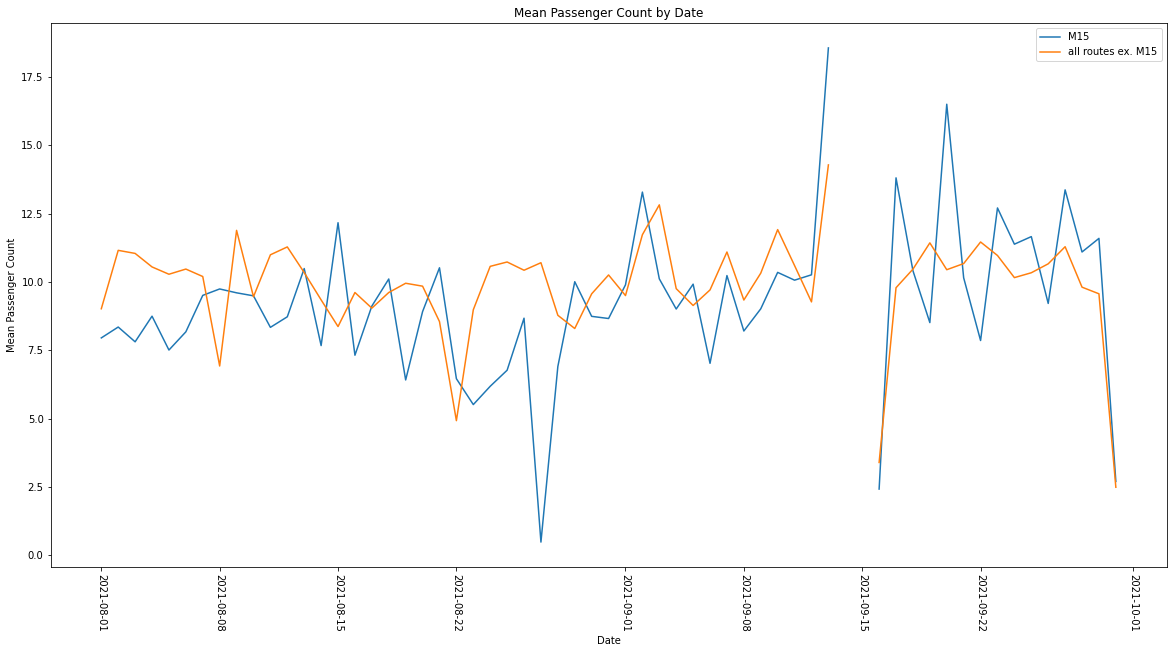

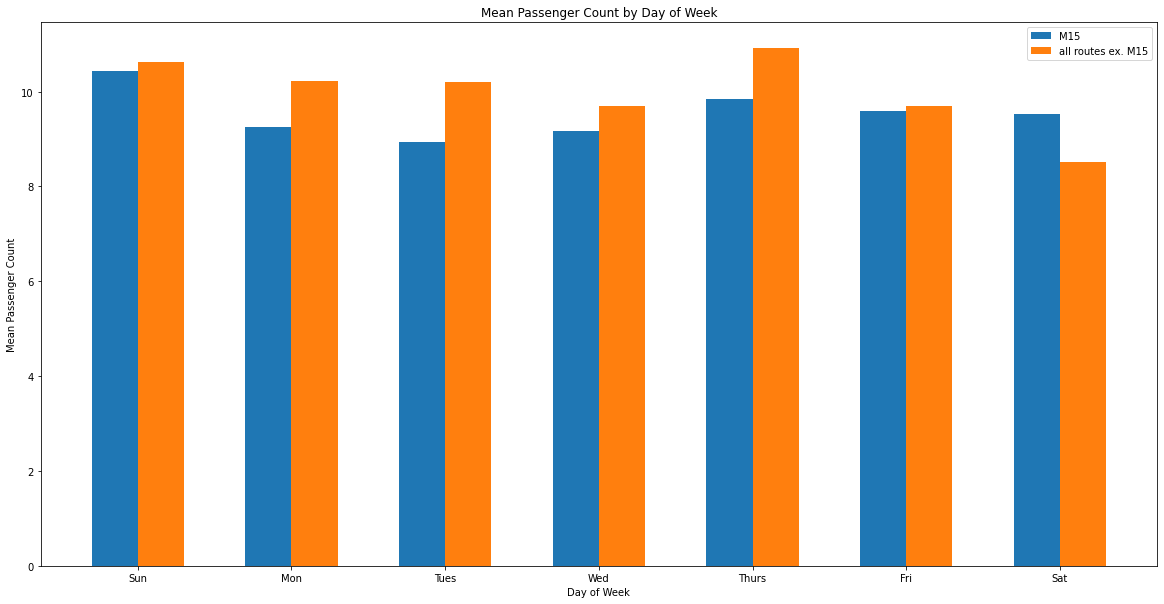

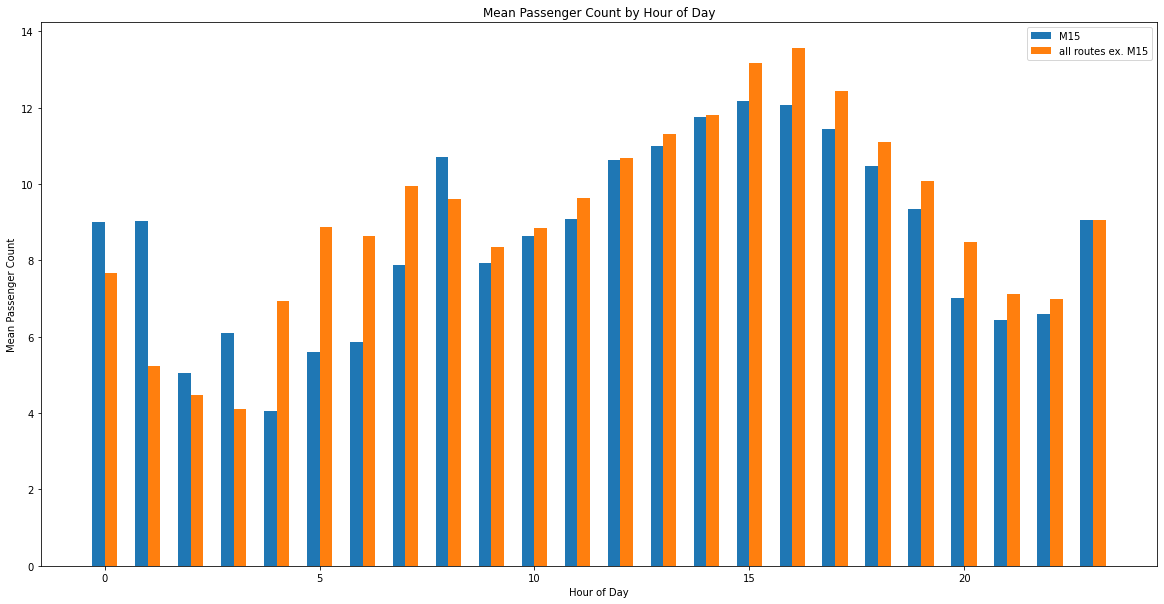

In [ ]:
analyze_route(buswatcher_data_for_modeling, 'M15')

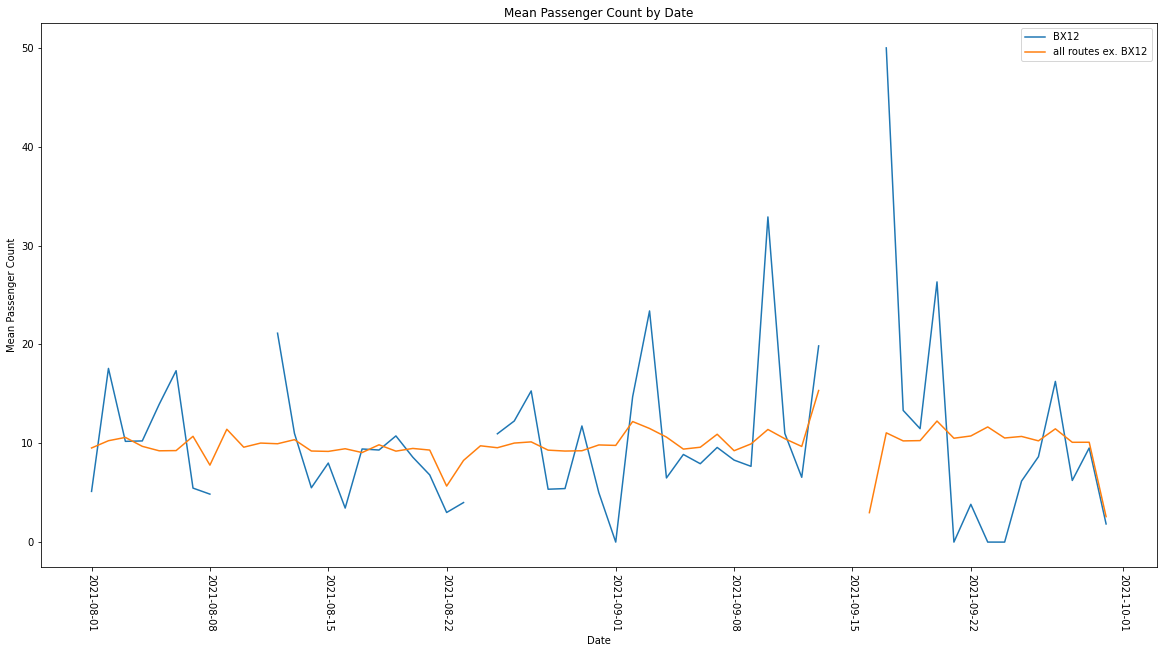

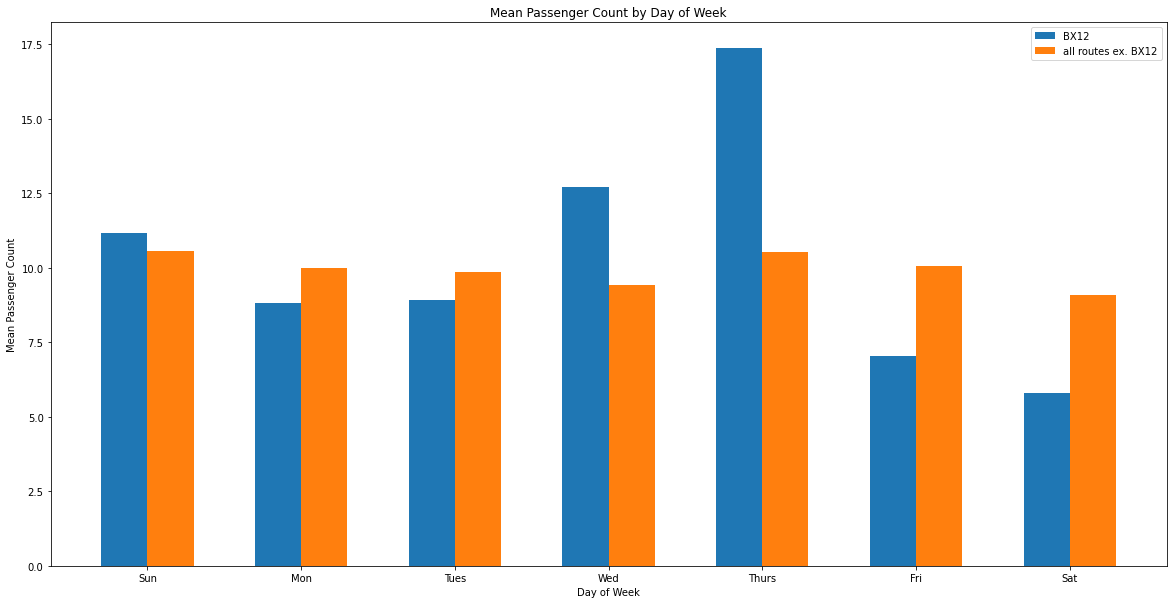

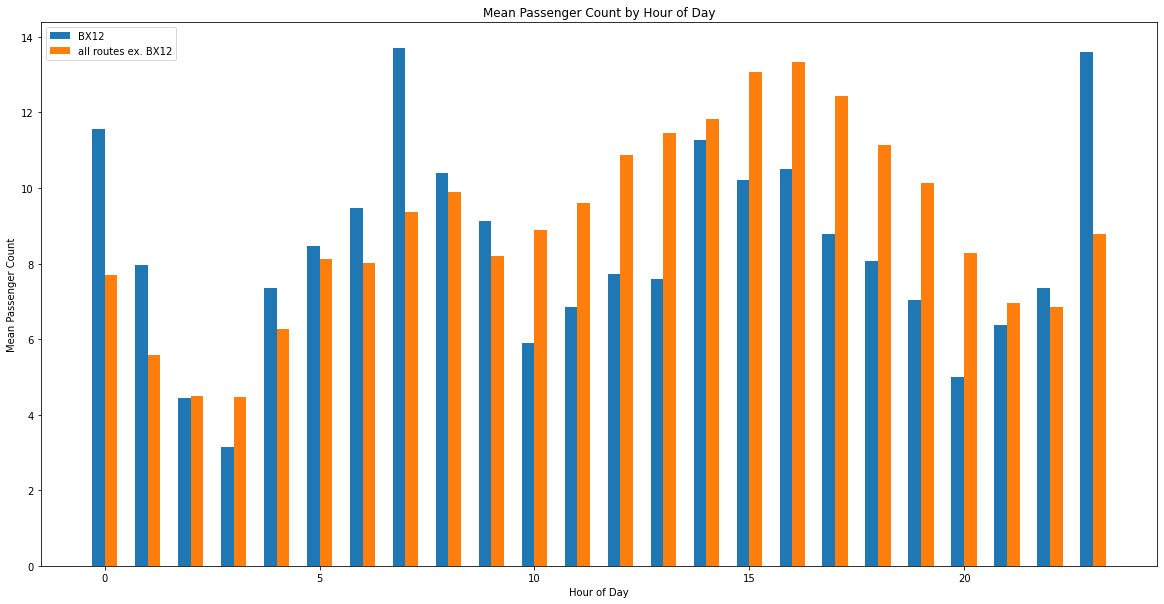

In [ ]:
analyze_route(buswatcher_data_for_modeling, 'BX12')

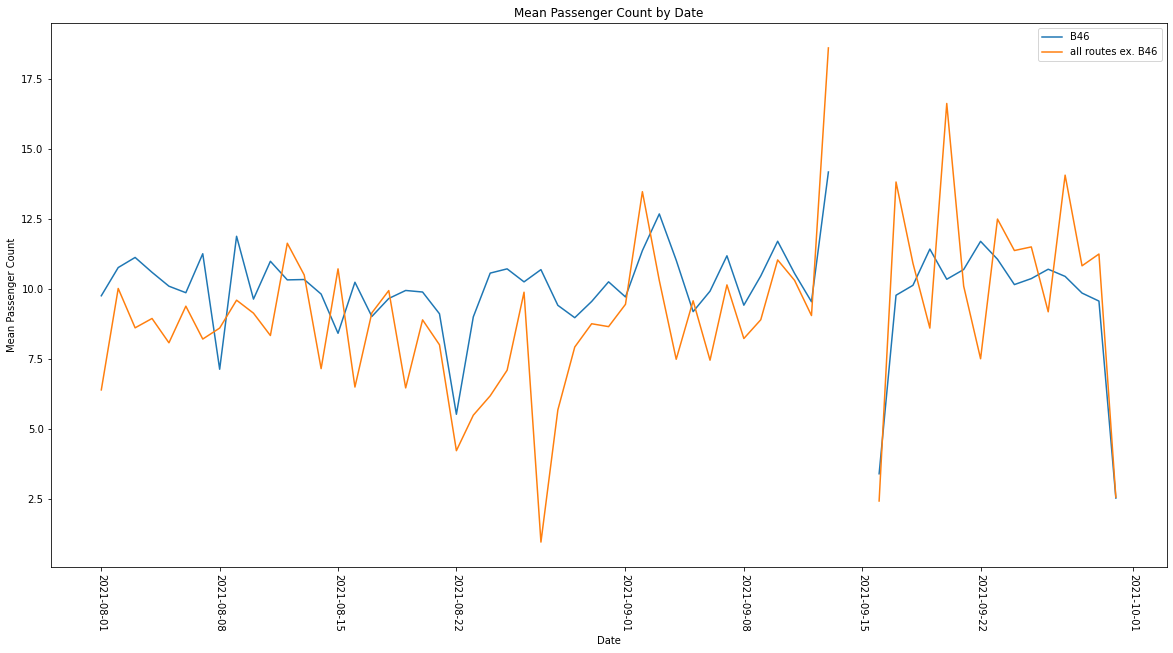

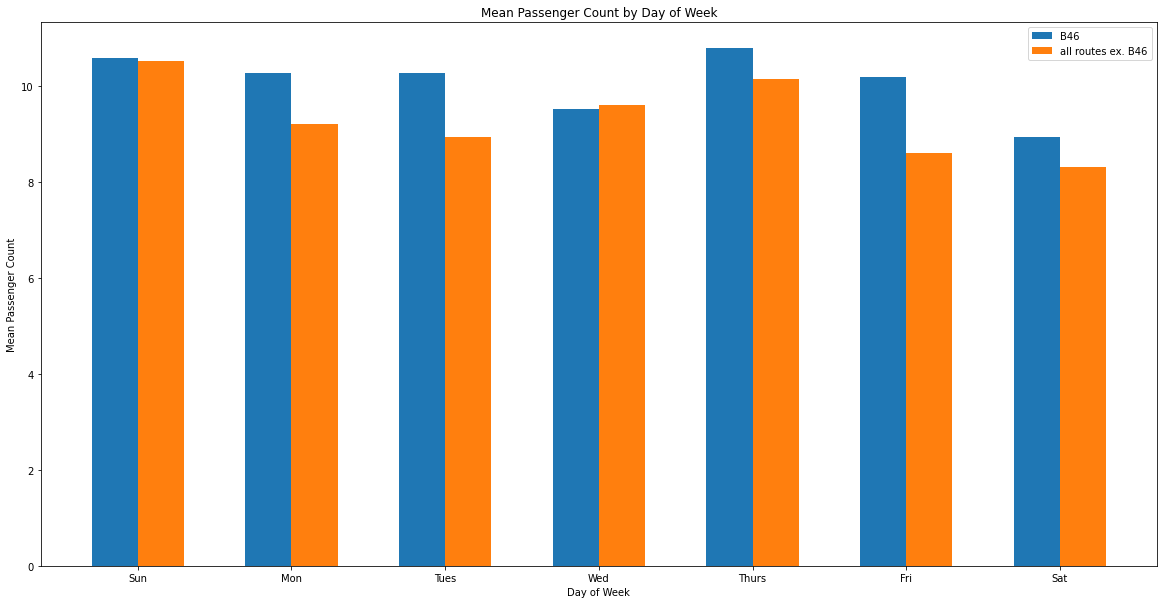

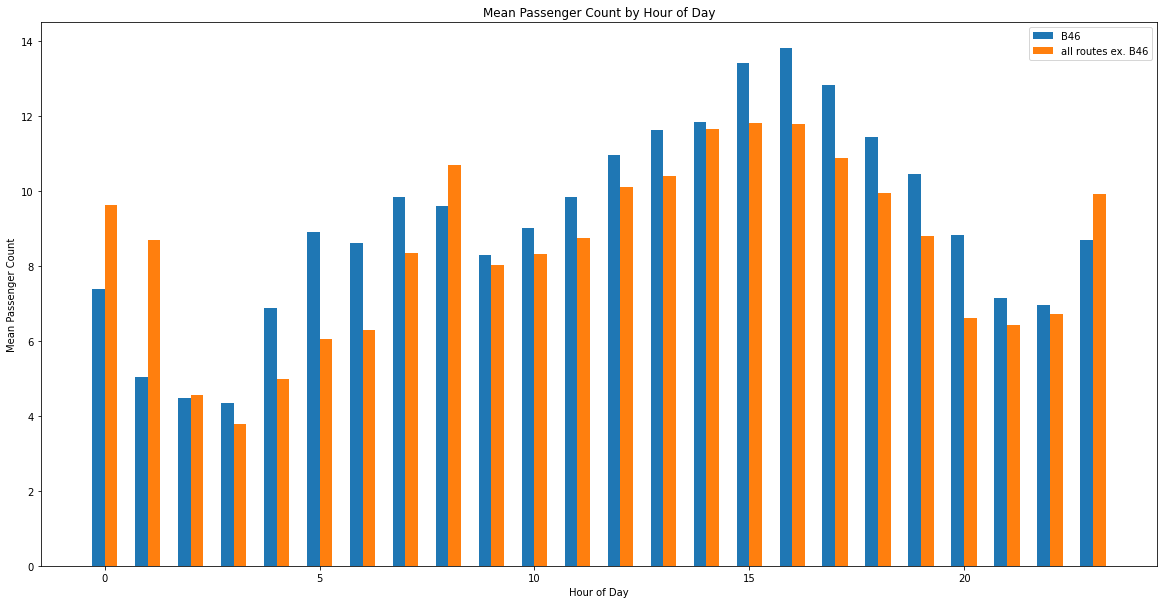

In [ ]:
analyze_route(buswatcher_data_for_modeling, 'B46')